# Imports:

In [185]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import matplotlib.colors as mcolors
from datetime import datetime
from datetime import timedelta as dt
from obspy.core.utcdatetime import UTCDateTime  
import h5py
from scipy.signal import butter, filtfilt

# Preliminary testing and examination of dataset:

In [53]:
filepath_picks = ""
test_pick = "F:\GitHub_files\FM_Segmentation_DAS\src\data\pick_masking\CIDAS_picks.csv"
#test_pick = "SSH file path"

In [54]:
# pull out the data from the pick file where there are not Nan values for either trace_s_arrivals or trace_p_arrivals or both
df = pd.read_csv(test_pick)
df

C:\Users\alexa\AppData\Local\Temp\ipykernel_24260\1371331190.py:2: DtypeWarning: Columns (7,8,9,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(test_pick)


,event_id,source_type,station_network_code,station_channel_code,station_code,station_location_code,station_latitude_deg,station_longitude_deg,station_elevation_m,trace_name,trace_sampling_rate_hz,trace_start_time,trace_S_arrival_sample,trace_P_arrival_sample,trace_S_onset,trace_P_onset,trace_snr_db,trace_s_arrival,trace_p_arrival
0,,,,,,,,,,,,,,,,,,,
1,,,CIDAS,,das0,,59.3535133831,-152.119676244,-62.9264913353,,25,2023-12-30T22:35:57.200000Z,,,,,,2023-12-30T22:36:42.180000Z,2023-12-30T22:36:25.860000Z
2,,,CIDAS,,das0,,59.3535133831,-152.119676244,-62.9264913353,,25,2023-12-30T19:35:57.200000Z,,,,,,NaN,NaN
3,,,CIDAS,,das0,,59.3535133831,-152.119676244,-62.9264913353,,25,2023-12-30T08:00:57.200000Z,,,,,,2023-12-30T08:01:06.430000Z,NaN
4,,,CIDAS,,das0,,59.3535133831,-152.119676244,-62.9264913353,,25,2023-12-29T11:33:57.200000Z,,,,,,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42746,,,CIDAS,,das4490,,59.58414,-152.343681,-55.999752,,25,2023-12-02T01:57:56.880000Z,,,,,,2023-12-02T01:58:11.270000Z,NaN
42747,,,CIDAS,,das4490,,59.58414,-152.343681,-55.999752,,25,2023-12-02T01:38:56.880000Z,,,,,,NaN,NaN
42748,,,CIDAS,,das4490,,59.58414,-152.343681,-55.999752,,25,2023-12-01T16:32:56.880000Z,,,,,,NaN,NaN
42749,,,CIDAS,,das4490,,59.58414,-152.343681,-55.999752,,25,2023-12-01T10:32:56.880000Z,,,,,,NaN,NaN


In [55]:
# datetime interaction

# Function to safely convert timestamps
def safe_to_datetime(timestamp):
    try:
        return UTCDateTime(timestamp).datetime
    except Exception:
        return pd.NaT

# Apply the safe conversion function
df['trace_start_time_unix'] = df['trace_start_time'].apply(safe_to_datetime)

# Convert to Unix timestamp (seconds since epoch)
df['trace_start_time_unix'] = df['trace_start_time_unix'].apply(lambda x: x.timestamp() if x is not pd.NaT else pd.NaT)

In [56]:
# Function to safely convert timestamps
def safe_to_datetime(timestamp):
    try:
        return UTCDateTime(timestamp).datetime
    except Exception:
        return pd.NaT

# Apply the safe conversion function
df['trace_p_arrival_unix'] = df['trace_p_arrival'].apply(safe_to_datetime)

# Convert to Unix timestamp (seconds since epoch)
df['trace_p_arrival_unix'] = df['trace_p_arrival_unix'].apply(lambda x: x.timestamp() if x is not pd.NaT else pd.NaT)



In [57]:
# Function to safely convert timestamps
def safe_to_datetime(timestamp):
    try:
        return UTCDateTime(timestamp).datetime
    except Exception:
        return pd.NaT

# Apply the safe conversion function
df['trace_s_arrival_unix'] = df['trace_s_arrival'].apply(safe_to_datetime)

# Convert to Unix timestamp (seconds since epoch)
df['trace_s_arrival_unix'] = df['trace_s_arrival_unix'].apply(lambda x: x.timestamp() if x is not pd.NaT else pd.NaT)



In [58]:
df['trace_p_arrival_sec'] = df['trace_p_arrival_unix'] - df['trace_start_time_unix']
df['trace_s_arrival_sec'] = df['trace_s_arrival_unix'] - df['trace_start_time_unix'] 

In [59]:
df

,event_id,source_type,station_network_code,station_channel_code,station_code,station_location_code,station_latitude_deg,station_longitude_deg,station_elevation_m,trace_name,...,trace_S_onset,trace_P_onset,trace_snr_db,trace_s_arrival,trace_p_arrival,trace_start_time_unix,trace_p_arrival_unix,trace_s_arrival_unix,trace_p_arrival_sec,trace_s_arrival_sec
0,,,,,,,,,,,...,,,,,,NaT,NaT,NaT,NaN,NaN
1,,,CIDAS,,das0,,59.3535133831,-152.119676244,-62.9264913353,,...,,,,2023-12-30T22:36:42.180000Z,2023-12-30T22:36:25.860000Z,1703975757.2,1703975785.86,1703975802.18,28.66,44.98
2,,,CIDAS,,das0,,59.3535133831,-152.119676244,-62.9264913353,,...,,,,NaN,NaN,1703964957.2,NaT,NaT,NaN,NaN
3,,,CIDAS,,das0,,59.3535133831,-152.119676244,-62.9264913353,,...,,,,2023-12-30T08:01:06.430000Z,NaN,1703923257.2,NaT,1703923266.43,NaN,9.23
4,,,CIDAS,,das0,,59.3535133831,-152.119676244,-62.9264913353,,...,,,,NaN,NaN,1703849637.2,NaT,NaT,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42746,,,CIDAS,,das4490,,59.58414,-152.343681,-55.999752,,...,,,,2023-12-02T01:58:11.270000Z,NaN,1701482276.88,NaT,1701482291.27,NaN,14.39
42747,,,CIDAS,,das4490,,59.58414,-152.343681,-55.999752,,...,,,,NaN,NaN,1701481136.88,NaT,NaT,NaN,NaN
42748,,,CIDAS,,das4490,,59.58414,-152.343681,-55.999752,,...,,,,NaN,NaN,1701448376.88,NaT,NaT,NaN,NaN
42749,,,CIDAS,,das4490,,59.58414,-152.343681,-55.999752,,...,,,,NaN,NaN,1701426776.88,NaT,NaT,NaN,NaN


In [60]:
grouped_df = df.groupby('trace_start_time').apply(lambda x: x)

#add an additional column which is the number that is that is in the followed by das in the station_code column 
grouped_df['das_number'] = grouped_df['station_code'].str.extract('(\d+)')
grouped_df

C:\Users\alexa\AppData\Local\Temp\ipykernel_24260\3571767727.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped_df = df.groupby('trace_start_time').apply(lambda x: x)


event_id source_type station_network_code  \
trace_start_time                                                              
                            0                                                 
2023-12-01T05:50:56.880000Z 21470                                     CIDAS   
                            21565                                     CIDAS   
                            21660                                     CIDAS   
                            21755                                     CIDAS   
...                                    ...         ...                  ...   
2023-12-30T22:35:57.200000Z 20901                                     CIDAS   
                            20996                                     CIDAS   
                            21091                                     CIDAS   
                            21186                                     CIDAS   
                            21281                                     CIDAS   

                                  station_channel_code station_code  \
trace_start_time                                                      
                            0                                         
2023-12-01T05:50:56.880000Z 21470                           das2250   
                            21565                           das2260   
                            21660                           das2270   
                            21755                           das2280   
...                                                ...          ...   
2023-12-30T22:35:57.200000Z 20901                           das2200   
                            20996                           das2210   
                            21091                           das2220   
                            21186                           das2230   
                            21281                           das2240   

                                  station_location_code station_latitude_deg  \
trace_start_time                                                               
                            0                                                  
2023-12-01T05:50:56.880000Z 21470                              59.6231316964   
                            21565                              59.6225635216   
                            21660                              59.6219952682   
                            21755                               59.621426936   
...                                                 ...                  ...   
2023-12-30T22:35:57.200000Z 20901                              59.6051334253   
                            20996                              59.6065711433   
                            21091                              59.6082059641   
                            21186                              59.6086841406   
                            21281                              59.6101172901   

                                  station_longitude_deg station_elevation_m  \
trace_start_time                                                              
                            0                                                 
2023-12-01T05:50:56.880000Z 21470         -151.61228522      -17.3175342765   
                            21565        -151.615487668      -18.7937778432   
                            21660        -151.618690008      -20.2679850174   
                            21755        -151.621892241       -21.586400689   
...                                                 ...                 ...   
2023-12-30T22:35:57.200000Z 20901        -151.582361186      -25.6091513457   
                            20996        -151.580517482      -23.9690764135   
                            21091        -151.580760677      -22.6053314043   
                            21186        -151.578191349      -21.4473477359   
                            21281        -151.576318745      -19.8287074186   

             

In [61]:
#plot the das number vs the trace_p_arrival_sec and trace_s_arrival_sec for one trace_start_time

unique_trace_start_times = grouped_df.index.get_level_values('trace_start_time').unique()
print(unique_trace_start_times)

folder_name = 'F:\DAS'


# for i in unique_trace_start_times:
#     grouped_df[grouped_df.index.get_level_values('trace_start_time') == i].plot(x='das_number', y='trace_p_arrival_sec', kind='scatter')
#     plt.title('trace_p_arrival_sec vs das_number for trace_start_time')
#     png_name = 'trace_p_arrival_sec_vs_das_number_for_trace_start_time_' + str(i) + '.png'
#     plt.savefig(png_name)

Index([' ', '2023-12-01T05:50:56.880000Z', '2023-12-01T05:50:57.200000Z',
       '2023-12-01T10:32:56.880000Z', '2023-12-01T10:32:57.200000Z',
       '2023-12-01T16:32:56.880000Z', '2023-12-01T16:32:57.200000Z',
       '2023-12-02T01:38:56.880000Z', '2023-12-02T01:38:57.200000Z',
       '2023-12-02T01:57:56.880000Z',
       ...
       '2023-12-29T02:13:56.880000Z', '2023-12-29T02:13:57.200000Z',
       '2023-12-29T11:33:56.880000Z', '2023-12-29T11:33:57.200000Z',
       '2023-12-30T08:00:56.880000Z', '2023-12-30T08:00:57.200000Z',
       '2023-12-30T19:35:56.880000Z', '2023-12-30T19:35:57.200000Z',
       '2023-12-30T22:35:56.880000Z', '2023-12-30T22:35:57.200000Z'],
      dtype='object', name='trace_start_time', length=187)


In [62]:
import os

# Preliminary for loop for generating initial pick plots:

In [63]:
# number = 0
# for i in unique_trace_start_times:
#     number += 1
#     plt.figure(figsize=(10, 6))
#     for col in ['trace_s_arrival_sec']:
#         if grouped_df.loc[i, col].isna().any():
#             print(f"NaN values found in {col} for trace_start_time {i}")
#         else:
#             grouped_df[grouped_df.index.get_level_values('trace_start_time') == i].plot(x='das_number', y='trace_s_arrival_sec', kind='scatter', color = "blue")

#     for col in  ['trace_p_arrival_sec']:      
#         if grouped_df.loc[i, col].isna().any():
#             print(f"NaN values found in {col} for trace_start_time {i}")
#         else:
#             grouped_df[grouped_df.index.get_level_values('trace_start_time') == i].plot(x='das_number', y='trace_p_arrival_sec', kind='scatter', color = "red")
    
#     # Define directory and filename
#     directory = "F:/DAS/pick_plots"
#     filename = str(number) + ".png"

#     # Combine directory and filename
#     filepath = os.path.join(directory, filename)

#     # Save the plot
#     plt.savefig(filepath)
#     plt.close()





# Continuation of earlier steps while interpolating values inbetween picks:

### Possibly better for loop:

Dropping columns that have Nan values for both trace_s_arrival and trace_p_arrival

In [64]:
# Drop rows where both 'trace_s_arrival_sec' and 'trace_p_arrival_sec' are NaN
df_dropped = df.dropna(subset=['trace_s_arrival_sec', 'trace_p_arrival_sec'], how='all')

# Display the updated dataframe
df_dropped

,event_id,source_type,station_network_code,station_channel_code,station_code,station_location_code,station_latitude_deg,station_longitude_deg,station_elevation_m,trace_name,...,trace_S_onset,trace_P_onset,trace_snr_db,trace_s_arrival,trace_p_arrival,trace_start_time_unix,trace_p_arrival_unix,trace_s_arrival_unix,trace_p_arrival_sec,trace_s_arrival_sec
1,,,CIDAS,,das0,,59.3535133831,-152.119676244,-62.9264913353,,...,,,,2023-12-30T22:36:42.180000Z,2023-12-30T22:36:25.860000Z,1703975757.2,1703975785.86,1703975802.18,28.66,44.98
3,,,CIDAS,,das0,,59.3535133831,-152.119676244,-62.9264913353,,...,,,,2023-12-30T08:01:06.430000Z,NaN,1703923257.2,NaT,1703923266.43,NaN,9.23
5,,,CIDAS,,das0,,59.3535133831,-152.119676244,-62.9264913353,,...,,,,2023-12-29T02:14:32.170001Z,2023-12-29T02:14:15.740001Z,1703816037.2,1703816055.740001,1703816072.170001,18.540001,34.970001
6,,,CIDAS,,das0,,59.3535133831,-152.119676244,-62.9264913353,,...,,,,2023-12-28T14:18:34.770000Z,NaN,1703773077.2,NaT,1703773114.77,NaN,37.57
9,,,CIDAS,,das0,,59.3535133831,-152.119676244,-62.9264913353,,...,,,,2023-12-27T05:06:51.030002Z,2023-12-27T05:06:44.650001Z,1703653557.2,1703653604.650001,1703653611.030002,47.450001,53.830002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42728,,,CIDAS,,das4490,,59.58414,-152.343681,-55.999752,,...,,,,NaN,2023-12-07T02:57:51.220000Z,1701917816.88,1701917871.22,NaT,54.34,NaN
42737,,,CIDAS,,das4490,,59.58414,-152.343681,-55.999752,,...,,,,2023-12-05T05:24:22.730000Z,NaN,1701753836.88,NaT,1701753862.73,NaN,25.85
42741,,,CIDAS,,das4490,,59.58414,-152.343681,-55.999752,,...,,,,2023-12-03T07:30:33.179999Z,NaN,1701588596.88,NaT,1701588633.179999,NaN,36.299999
42746,,,CIDAS,,das4490,,59.58414,-152.343681,-55.999752,,...,,,,2023-12-02T01:58:11.270000Z,NaN,1701482276.88,NaT,1701482291.27,NaN,14.39


regrouping

In [65]:
#asked chatgpt how to group by trace_start_time and apply the function to the grouped dataframe
grouped_df_dropped = df_dropped.groupby('trace_start_time').apply(lambda x: x)
grouped_df_dropped

#add an additional column which is the number that is that is in the followed by das in the station_code column 
grouped_df_dropped['das_number'] = grouped_df_dropped['station_code'].str.extract('(\d+)')
grouped_df_dropped

C:\Users\alexa\AppData\Local\Temp\ipykernel_24260\1883995730.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped_df_dropped = df_dropped.groupby('trace_start_time').apply(lambda x: x)


event_id source_type station_network_code  \
trace_start_time                                                              
2023-12-01T05:50:56.880000Z 21470                                     CIDAS   
                            21565                                     CIDAS   
                            21660                                     CIDAS   
                            21755                                     CIDAS   
                            21850                                     CIDAS   
...                                    ...         ...                  ...   
2023-12-30T22:35:57.200000Z 20806                                     CIDAS   
                            20901                                     CIDAS   
                            20996                                     CIDAS   
                            21186                                     CIDAS   
                            21281                                     CIDAS   

                                  station_channel_code station_code  \
trace_start_time                                                      
2023-12-01T05:50:56.880000Z 21470                           das2250   
                            21565                           das2260   
                            21660                           das2270   
                            21755                           das2280   
                            21850                           das2290   
...                                                ...          ...   
2023-12-30T22:35:57.200000Z 20806                           das2190   
                            20901                           das2200   
                            20996                           das2210   
                            21186                           das2230   
                            21281                           das2240   

                                  station_location_code station_latitude_deg  \
trace_start_time                                                               
2023-12-01T05:50:56.880000Z 21470                              59.6231316964   
                            21565                              59.6225635216   
                            21660                              59.6219952682   
                            21755                               59.621426936   
                            21850                              59.6208585253   
...                                                 ...                  ...   
2023-12-30T22:35:57.200000Z 20806                              59.6037060557   
                            20901                              59.6051334253   
                            20996                              59.6065711433   
                            21186                              59.6086841406   
                            21281                              59.6101172901   

                                  station_longitude_deg station_elevation_m  \
trace_start_time                                                              
2023-12-01T05:50:56.880000Z 21470         -151.61228522      -17.3175342765   
                            21565        -151.615487668      -18.7937778432   
                            21660        -151.618690008      -20.2679850174   
                            21755        -151.621892241       -21.586400689   
                            21850        -151.625094367      -23.2750093549   
...                                                 ...                 ...   
2023-12-30T22:35:57.200000Z 20806        -151.584250629      -26.9169346047   
                            20901        -151.582361186      -25.6091513457   
                            20996        -151.580517482      -23.9690764135   
                            21186        -151.578191349      -21.4473477359   
                            21281        -151.576318745      -19.8287074186   

             

In [66]:
#indexing all of the invidual trace_start_time values in the grouped dataframe
unique_trace_start_times_dropped = grouped_df_dropped.index.get_level_values('trace_start_time').unique()
print(unique_trace_start_times_dropped)

Index(['2023-12-01T05:50:56.880000Z', '2023-12-01T05:50:57.200000Z',
       '2023-12-02T01:38:56.880000Z', '2023-12-02T01:38:57.200000Z',
       '2023-12-02T01:57:56.880000Z', '2023-12-02T01:57:57.200000Z',
       '2023-12-02T10:27:56.880000Z', '2023-12-02T10:27:57.200000Z',
       '2023-12-02T14:56:56.880000Z', '2023-12-02T14:56:57.200000Z',
       ...
       '2023-12-28T14:17:56.880000Z', '2023-12-28T14:17:57.200000Z',
       '2023-12-29T02:13:56.880000Z', '2023-12-29T02:13:57.200000Z',
       '2023-12-30T08:00:56.880000Z', '2023-12-30T08:00:57.200000Z',
       '2023-12-30T19:35:56.880000Z', '2023-12-30T19:35:57.200000Z',
       '2023-12-30T22:35:56.880000Z', '2023-12-30T22:35:57.200000Z'],
      dtype='object', name='trace_start_time', length=147)


In [67]:
min_trace_p_arrival_sec = grouped_df_dropped['trace_p_arrival_sec'].min()
max_trace_p_arrival_sec = grouped_df_dropped['trace_p_arrival_sec'].max()
min_trace_s_arrival_sec = grouped_df_dropped['trace_s_arrival_sec'].min()
max_trace_s_arrival_sec = grouped_df_dropped['trace_s_arrival_sec'].max()

print("Min trace_p_arrival_sec:", min_trace_p_arrival_sec)
print("Max trace_p_arrival_sec:", max_trace_p_arrival_sec)
print("Min trace_s_arrival_sec:", min_trace_s_arrival_sec)
print("Max trace_s_arrival_sec:", max_trace_s_arrival_sec)


Min trace_p_arrival_sec: 5.009999990463257
Max trace_p_arrival_sec: 54.990001916885376
Min trace_s_arrival_sec: 7.6499998569488525
Max trace_s_arrival_sec: 54.980000019073486


In [68]:
# import numpy as np

# for i in unique_trace_start_times_dropped:
#     if i.strip() == '':
#         print(f"Skipping invalid trace_start_time: '{i}'")
#         continue
    
#     # Define directory and filename
#     # Convert i into a string with format YYYYMMDD_HHMMSS
#     name = str(i).replace(" ", "_").replace(":", "_").replace("-", "_").replace(".", "_")
    
#     directory = "F:/DAS/pick_plots_new"
#     filename = str(name) + ".png"

#     # Combine directory and filename
#     filepath = os.path.join(directory, filename)

#     plt.figure(figsize=(10, 6))
  

#     subset = grouped_df_dropped.loc[i]

#     plt.plot(subset['das_number'], subset['trace_p_arrival_sec'], 'o', color='blue', label='P Arrival')
#     plt.plot(subset['das_number'], subset['trace_s_arrival_sec'], 'o', color='red', label='S Arrival')

#     plt.title(f'Trace Arrivals vs Channel for {i}')
#     plt.xlabel('Channel')
#     plt.ylabel('Arrival Time (sec)')
#     plt.ylim(0, 60)
#     plt.legend()

#     # Set the number of ticks to 5
#     plt.gca().xaxis.set_major_locator(MaxNLocator(5))
#     #change the number of ticks on the x axis to be 5 total
#     # Save the plot
#     plt.savefig(filepath)
#     plt.close()
    

## Test with normalizing and interpolating (need to turn into a function like above)

# Numpy files for training

### 6 sec 2023-12-30T22:35:57.2000000Z - cells below take the individual DAS file location + pick time to extract and make 2 numpy arrays based on where the pick is located

#### Background

In [123]:
# decide the amount of seconds you want to add to the mask after the arrival time for p and s waves

p_arrival_mask = 6
s_arrival_mask = 6

In [124]:
# Select the specific row based on the index
data_2023_12_30 = grouped_df_dropped.loc['2023-12-30T22:35:57.200000Z']

# Select specific columns from the row
dropped_dataset = data_2023_12_30[['trace_p_arrival_sec', 'trace_s_arrival_sec', 'das_number']]
p_dataset = dropped_dataset[['trace_p_arrival_sec','das_number']]
s_dataset = dropped_dataset[['trace_s_arrival_sec','das_number']]


In [125]:
p_dataset.dropna(subset=['trace_p_arrival_sec', "das_number"], inplace = True)
s_dataset.dropna(subset=['trace_s_arrival_sec', "das_number"], inplace = True)

C:\Users\alexa\AppData\Local\Temp\ipykernel_24260\751016926.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p_dataset.dropna(subset=['trace_p_arrival_sec', "das_number"], inplace = True)
C:\Users\alexa\AppData\Local\Temp\ipykernel_24260\751016926.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  s_dataset.dropna(subset=['trace_s_arrival_sec', "das_number"], inplace = True)


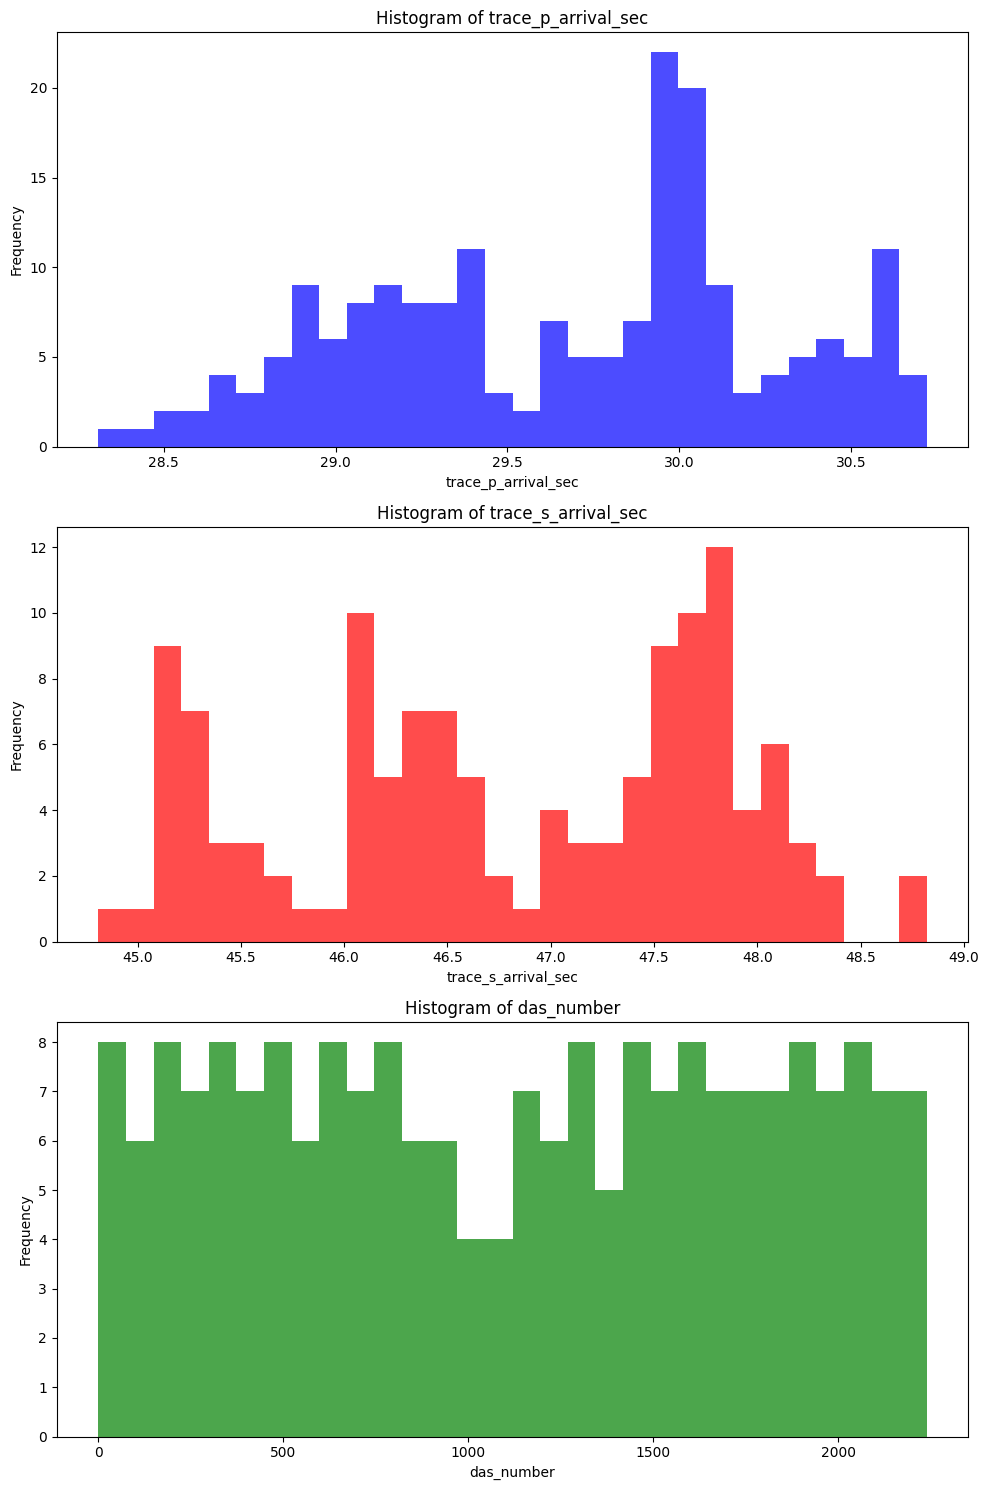

In [126]:
fig, axes = plt.subplots(3, 1, figsize=(10, 15))

# Histogram for trace_p_arrival_sec
axes[0].hist(pd.to_numeric(dropped_dataset['trace_p_arrival_sec'], errors='coerce').dropna(), bins=30, color='blue', alpha=0.7)
axes[0].set_title('Histogram of trace_p_arrival_sec')
axes[0].set_xlabel('trace_p_arrival_sec')
axes[0].set_ylabel('Frequency')

# Histogram for trace_s_arrival_sec
axes[1].hist(pd.to_numeric(dropped_dataset['trace_s_arrival_sec'], errors='coerce').dropna(), bins=30, color='red', alpha=0.7)
axes[1].set_title('Histogram of trace_s_arrival_sec')
axes[1].set_xlabel('trace_s_arrival_sec')
axes[1].set_ylabel('Frequency')

# Histogram for das_number
axes[2].hist(pd.to_numeric(dropped_dataset['das_number'], errors='coerce').dropna(), bins=30, color='green', alpha=0.7)
axes[2].set_title('Histogram of das_number')
axes[2].set_xlabel('das_number')
axes[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [127]:
# Was having issues later with interpolation so changing the data type to float
# convert das_number column to int
p_dataset['das_number'] = p_dataset['das_number'].astype(float)
s_dataset['das_number'] = s_dataset['das_number'].astype(float)
p_dataset['trace_p_arrival_sec'] = p_dataset['trace_p_arrival_sec'].astype(float)
s_dataset['trace_s_arrival_sec'] = s_dataset['trace_s_arrival_sec'].astype(float)



C:\Users\alexa\AppData\Local\Temp\ipykernel_24260\3263820701.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p_dataset['das_number'] = p_dataset['das_number'].astype(float)
C:\Users\alexa\AppData\Local\Temp\ipykernel_24260\3263820701.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  s_dataset['das_number'] = s_dataset['das_number'].astype(float)
C:\Users\alexa\AppData\Local\Temp\ipykernel_24260\3263820701.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.

In [128]:
# Dropping Nans in the p_dataset and s_dataset
p_dataset.dropna(subset=['trace_p_arrival_sec', "das_number"], inplace = True)
print(p_dataset["trace_p_arrival_sec"].isna())

1        False
96       False
191      False
286      False
381      False
         ...  
20711    False
20806    False
20996    False
21186    False
21281    False
Name: trace_p_arrival_sec, Length: 195, dtype: bool


C:\Users\alexa\AppData\Local\Temp\ipykernel_24260\2010603134.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p_dataset.dropna(subset=['trace_p_arrival_sec', "das_number"], inplace = True)


In [129]:
print(p_dataset["das_number"].dtype)
print(p_dataset["trace_p_arrival_sec"].dtype)
print(s_dataset["das_number"].dtype)
print(s_dataset["trace_s_arrival_sec"].dtype)


float64
float64
float64
float64


In [130]:
print(p_dataset["das_number"].values)
print(p_dataset["trace_p_arrival_sec"].values)
print(s_dataset["das_number"].values)
print(s_dataset["trace_s_arrival_sec"].values)


[   0.   10.   20.   30.   40.   50.   60.   70.   80.   90.  120.  130.
  140.  150.  160.  170.  180.  190.  210.  220.  230.  240.  250.  260.
  280.  290.  300.  310.  320.  330.  340.  350.  360.  370.  380.  390.
  400.  410.  420.  430.  440.  450.  460.  470.  480.  490.  500.  510.
  520.  530.  540.  550.  580.  590.  600.  610.  620.  630.  640.  650.
  670.  690.  700.  710.  720.  730.  740.  750.  760.  780.  790.  800.
  810.  820.  840.  850.  860.  870.  880.  890.  900.  910.  920.  940.
  950. 1000. 1010. 1020. 1050. 1070. 1090. 1100. 1130. 1140. 1150. 1160.
 1170. 1180. 1190. 1200. 1230. 1240. 1250. 1260. 1270. 1280. 1290. 1300.
 1320. 1330. 1340. 1360. 1370. 1380. 1400. 1410. 1420. 1430. 1440. 1450.
 1460. 1470. 1480. 1490. 1510. 1520. 1530. 1540. 1550. 1560. 1570. 1580.
 1590. 1600. 1610. 1620. 1630. 1640. 1650. 1660. 1670. 1680. 1690. 1700.
 1710. 1720. 1730. 1740. 1750. 1760. 1780. 1790. 1800. 1810. 1820. 1830.
 1840. 1850. 1860. 1870. 1880. 1890. 1900. 1910. 19

In [131]:
# Fit individual polynomials for p_dataset and s_dataset
p_coeffs_individual = np.polyfit(p_dataset['das_number'].values, p_dataset['trace_p_arrival_sec'].values, deg=1)
s_coeffs_individual = np.polyfit(s_dataset['das_number'].values, s_dataset['trace_s_arrival_sec'].values, deg=1)

# # Calculate the trends
p_trend_individual = np.polyval(p_coeffs_individual, pd.to_numeric(p_dataset['das_number']))
s_trend_individual = np.polyval(s_coeffs_individual, pd.to_numeric(s_dataset['das_number']))

# # Detrend by subtracting the individual trends
p_dataset['trace_p_arrival_sec_detrended'] = p_dataset['trace_p_arrival_sec'] - p_trend_individual
s_dataset['trace_s_arrival_sec_detrended'] = s_dataset['trace_s_arrival_sec'] - s_trend_individual



C:\Users\alexa\AppData\Local\Temp\ipykernel_24260\1877243647.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p_dataset['trace_p_arrival_sec_detrended'] = p_dataset['trace_p_arrival_sec'] - p_trend_individual
C:\Users\alexa\AppData\Local\Temp\ipykernel_24260\1877243647.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  s_dataset['trace_s_arrival_sec_detrended'] = s_dataset['trace_s_arrival_sec'] - s_trend_individual


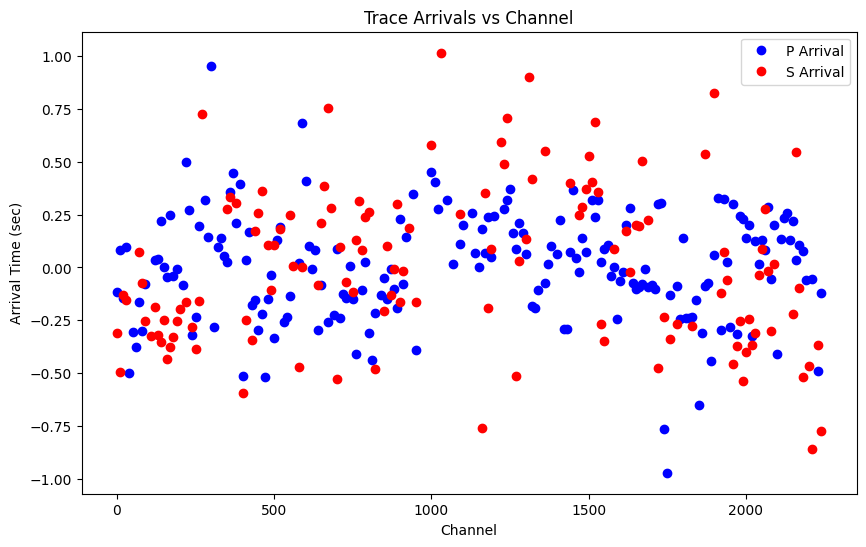

In [132]:
#plot to see detrended data and the distribution of the data compared between the p and s arrivals
plt.figure(figsize=(10, 6))
  

plt.plot(p_dataset['das_number'], p_dataset['trace_p_arrival_sec_detrended'], 'o', color='blue', label='P Arrival')
plt.plot(s_dataset['das_number'], s_dataset['trace_s_arrival_sec_detrended'], 'o', color='red', label='S Arrival')

plt.title(f'Trace Arrivals vs Channel')
plt.xlabel('Channel')
plt.ylabel('Arrival Time (sec)')
plt.legend()
# Set the number of ticks to 5
plt.gca().xaxis.set_major_locator(MaxNLocator(5))

Text(0, 0.5, 'Frequency')

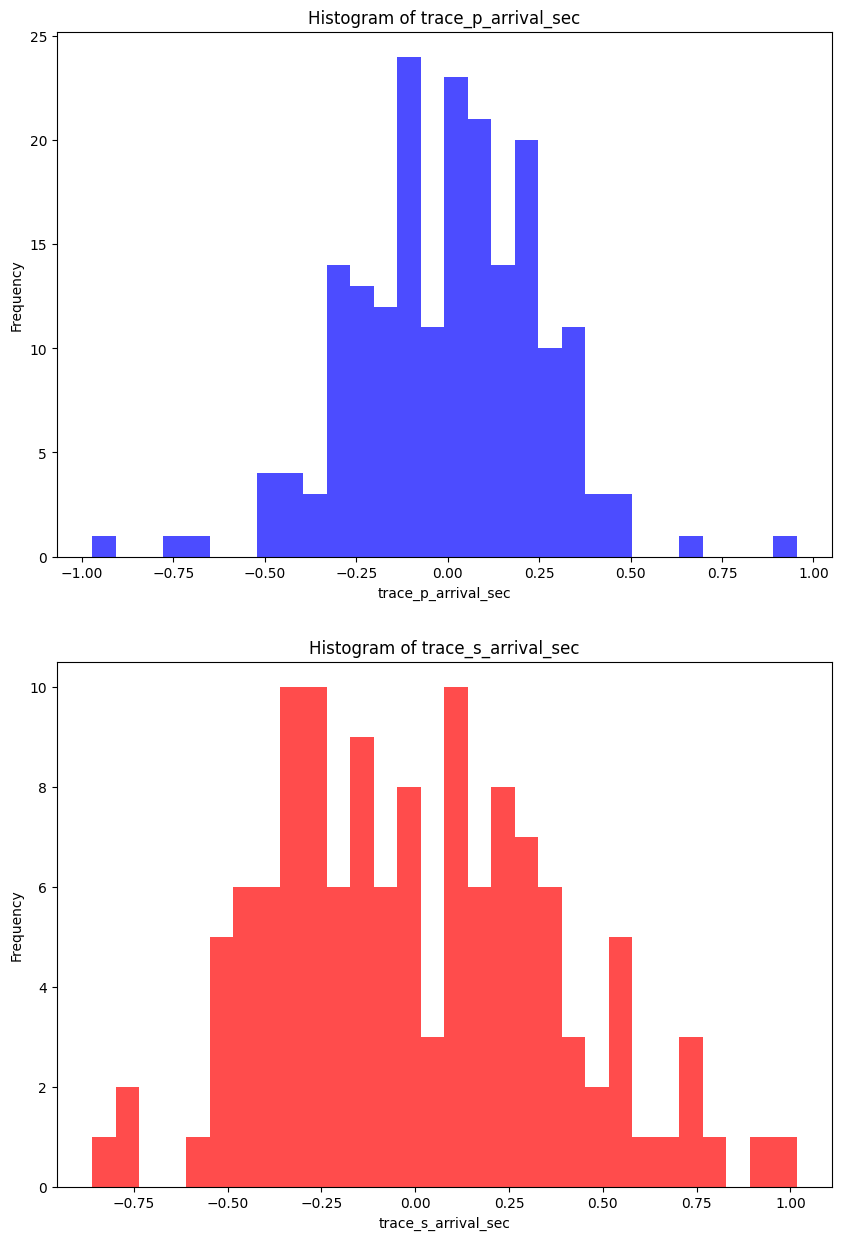

In [133]:
fig, axes = plt.subplots(2, 1, figsize=(10, 15))

# Histogram for trace_p_arrival_sec
axes[0].hist(pd.to_numeric(p_dataset['trace_p_arrival_sec_detrended'], errors='coerce').dropna(), bins=30, color='blue', alpha=0.7)
axes[0].set_title('Histogram of trace_p_arrival_sec')
axes[0].set_xlabel('trace_p_arrival_sec')
axes[0].set_ylabel('Frequency')

# Histogram for trace_s_arrival_sec
axes[1].hist(pd.to_numeric(s_dataset['trace_s_arrival_sec_detrended'], errors='coerce').dropna(), bins=30, color='red', alpha=0.7)
axes[1].set_title('Histogram of trace_s_arrival_sec')
axes[1].set_xlabel('trace_s_arrival_sec')
axes[1].set_ylabel('Frequency')


In [134]:
#calculate 2 standard deviations from the mean for the trace_p_arrival_sec and trace_s_arrival_sec columns
p_dataset_mean = p_dataset['trace_p_arrival_sec_detrended'].mean()
p_dataset_std = p_dataset['trace_p_arrival_sec_detrended'].std()
p_dataset_2std = 2 * p_dataset_std

print(p_dataset_mean)
print(p_dataset_std)
print(p_dataset_2std)



2.022313940240285e-15
0.25571951595899595
0.5114390319179919


In [135]:
# do it for s_dataset
s_dataset_mean = s_dataset['trace_s_arrival_sec_detrended'].mean()
s_dataset_std = s_dataset['trace_s_arrival_sec_detrended'].std()
s_dataset_2std = 2 * s_dataset_std

print(s_dataset_mean)
print(s_dataset_std)
print(s_dataset_2std)

1.0380585280245214e-14
0.3729898592187784
0.7459797184375568


In [136]:
#save values for index which are greater than 2 standard deviations from the mean for the trace_p_arrival_sec column
p_dataset_outliers = p_dataset[(p_dataset['trace_p_arrival_sec_detrended'].values > p_dataset_2std) | 
                               (p_dataset['trace_p_arrival_sec_detrended'].values < -p_dataset_2std)]

p_dataset_outliers

#replace p_dataset trace_p_arrival_sec and trace_p_arrival_sec_detrended with Nans for the das_number values that occur in p_dataset_outliers
p_dataset.loc[p_dataset_outliers.index, 'trace_p_arrival_sec'] = np.nan
p_dataset.loc[p_dataset_outliers.index, 'trace_p_arrival_sec_detrended'] = np.nan


#find the columns that are Nans
p_dataset[p_dataset['trace_p_arrival_sec'].isna()]

,trace_p_arrival_sec,das_number,trace_p_arrival_sec_detrended
2851,NaN,300.0,NaN
3801,NaN,400.0,NaN
4466,NaN,470.0,NaN
5606,NaN,590.0,NaN
16531,NaN,1740.0,NaN
16626,NaN,1750.0,NaN
17576,NaN,1850.0,NaN


In [137]:
# Save values for index which are greater than 2 standard deviations from the mean for the trace_s_arrival_sec column
s_dataset_outliers = s_dataset[(s_dataset['trace_s_arrival_sec_detrended'].values > s_dataset_2std) | 
                               (s_dataset['trace_s_arrival_sec_detrended'].values < -s_dataset_2std)]

s_dataset_outliers

# Replace s_dataset trace_s_arrival_sec and trace_s_arrival_sec_detrended with NaNs for the das_number values that occur in s_dataset_outliers
s_dataset.loc[s_dataset_outliers.index, 'trace_s_arrival_sec'] = np.nan
s_dataset.loc[s_dataset_outliers.index, 'trace_s_arrival_sec_detrended'] = np.nan

# Find the columns that are NaNs
s_dataset[s_dataset['trace_s_arrival_sec'].isna()]


,trace_s_arrival_sec,das_number,trace_s_arrival_sec_detrended
6366,NaN,670.0,NaN
9786,NaN,1030.0,NaN
11021,NaN,1160.0,NaN
12446,NaN,1310.0,NaN
18051,NaN,1900.0,NaN
20996,NaN,2210.0,NaN
21281,NaN,2240.0,NaN


Text(0, 0.5, 'Frequency')

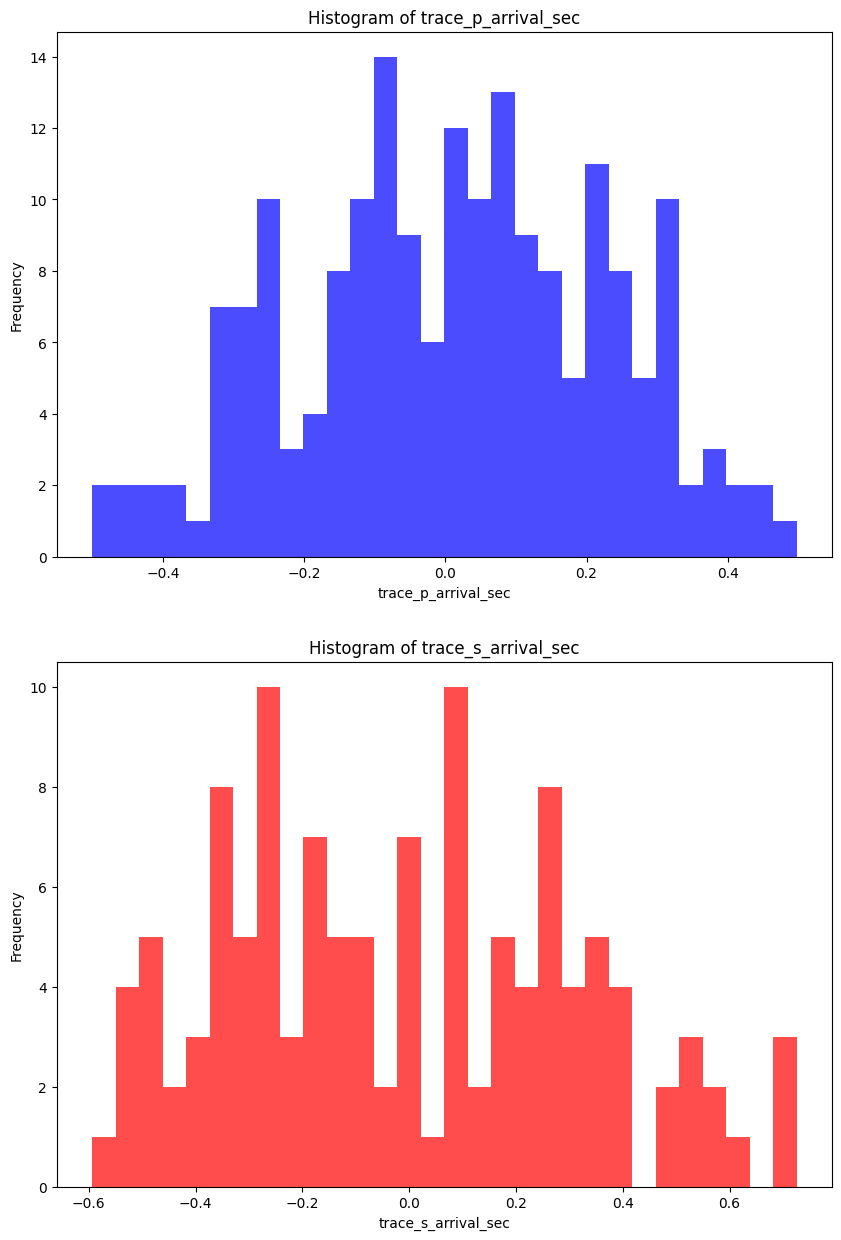

In [138]:
fig, axes = plt.subplots(2, 1, figsize=(10, 15))

# Histogram for trace_p_arrival_sec
axes[0].hist(pd.to_numeric(p_dataset['trace_p_arrival_sec_detrended'], errors='coerce').dropna(), bins=30, color='blue', alpha=0.7)
axes[0].set_title('Histogram of trace_p_arrival_sec')
axes[0].set_xlabel('trace_p_arrival_sec')
axes[0].set_ylabel('Frequency')

# Histogram for trace_s_arrival_sec
axes[1].hist(pd.to_numeric(s_dataset['trace_s_arrival_sec_detrended'], errors='coerce').dropna(), bins=30, color='red', alpha=0.7)
axes[1].set_title('Histogram of trace_s_arrival_sec')
axes[1].set_xlabel('trace_s_arrival_sec')
axes[1].set_ylabel('Frequency')

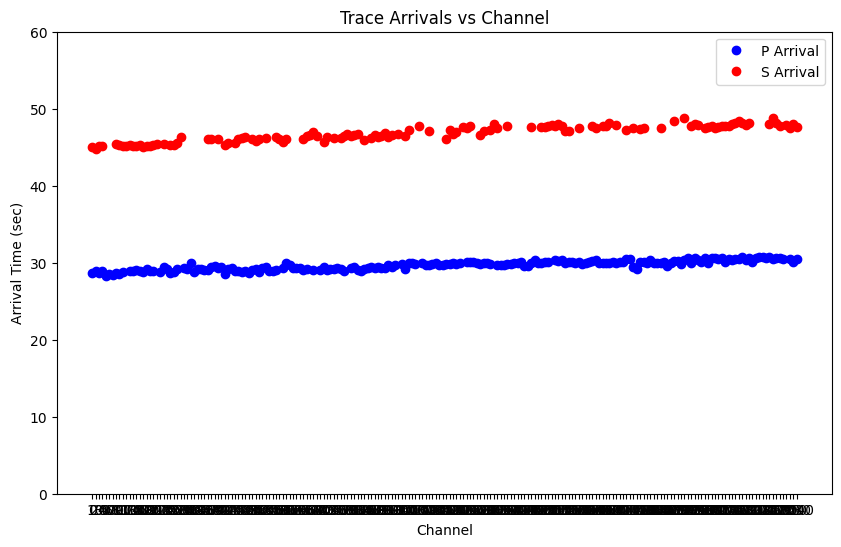

In [139]:
#original
plt.figure(figsize=(10, 6))


plt.plot(dropped_dataset['das_number'], dropped_dataset['trace_p_arrival_sec'], 'o', color='blue', label='P Arrival')
plt.plot(dropped_dataset['das_number'], dropped_dataset['trace_s_arrival_sec'], 'o', color='red', label='S Arrival')

plt.title(f'Trace Arrivals vs Channel')
plt.xlabel('Channel')
plt.ylabel('Arrival Time (sec)')
plt.ylim(0, 60)
plt.legend()

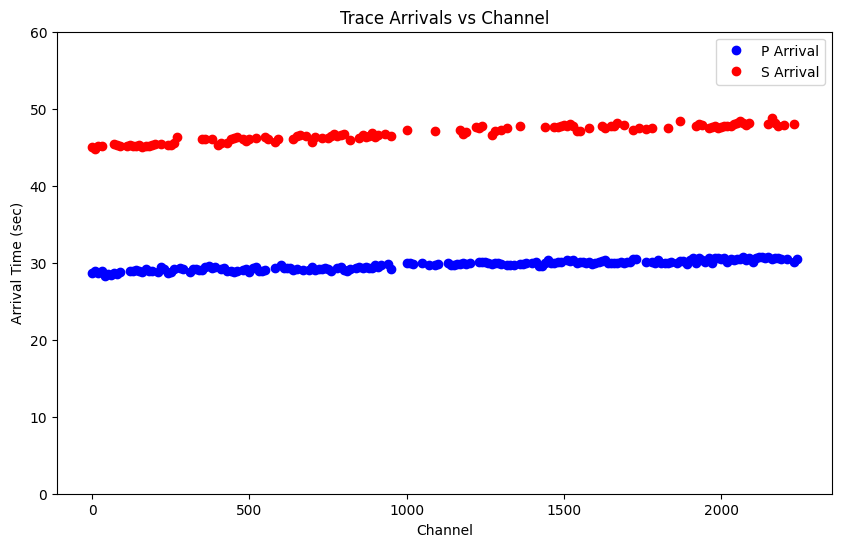

In [140]:
plt.figure(figsize=(10, 6))
  

plt.plot(p_dataset['das_number'], p_dataset['trace_p_arrival_sec'], 'o', color='blue', label='P Arrival')
plt.plot(s_dataset['das_number'], s_dataset['trace_s_arrival_sec'], 'o', color='red', label='S Arrival')

plt.title(f'Trace Arrivals vs Channel')
plt.xlabel('Channel')
plt.ylabel('Arrival Time (sec)')
plt.ylim(0, 60)
plt.legend()

In [141]:
#interpolate the missing values from the p_outliers and s_outliers dataframes using the interpolate function
p_dataset['trace_p_arrival_sec_interpolated'] = p_dataset['trace_p_arrival_sec'].interpolate()
s_dataset['trace_s_arrival_sec_interpolated'] = s_dataset['trace_s_arrival_sec'].interpolate()

s_dataset


C:\Users\alexa\AppData\Local\Temp\ipykernel_24260\3394753993.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p_dataset['trace_p_arrival_sec_interpolated'] = p_dataset['trace_p_arrival_sec'].interpolate()
C:\Users\alexa\AppData\Local\Temp\ipykernel_24260\3394753993.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  s_dataset['trace_s_arrival_sec_interpolated'] = s_dataset['trace_s_arrival_sec'].interpolate()


,trace_s_arrival_sec,das_number,trace_s_arrival_sec_detrended,trace_s_arrival_sec_interpolated
1,44.980000,0.0,-0.311748,44.980000
96,44.810001,10.0,-0.495546,44.810001
191,45.189999,20.0,-0.129347,45.189999
286,45.180000,30.0,-0.153145,45.180000
666,45.459999,70.0,0.071656,45.459999
...,...,...,...,...
20711,47.779999,2180.0,-0.519982,47.779999
20901,47.860001,2200.0,-0.467579,47.860001
20996,NaN,2210.0,NaN,47.930000
21186,48.000000,2230.0,-0.368977,48.000000


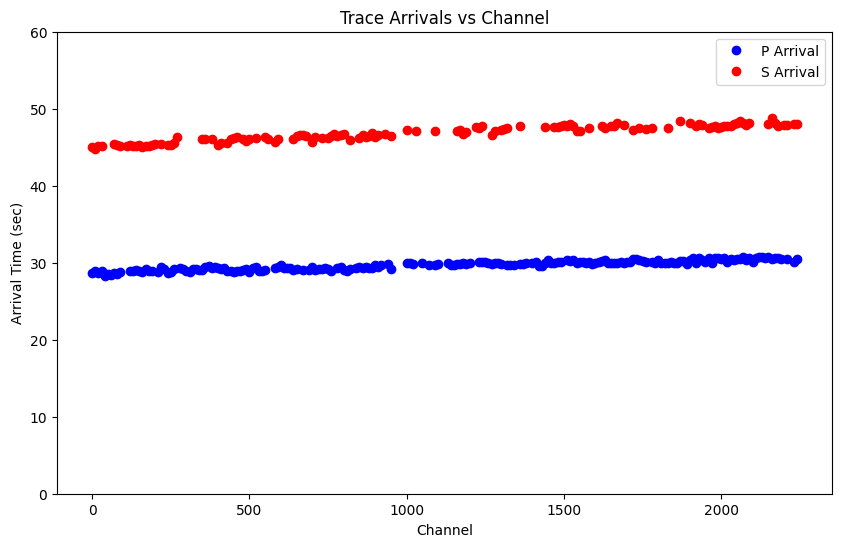

In [142]:
plt.figure(figsize=(10, 6))
  

plt.plot(p_dataset['das_number'], p_dataset['trace_p_arrival_sec_interpolated'], 'o', color='blue', label='P Arrival')
plt.plot(s_dataset['das_number'], s_dataset['trace_s_arrival_sec_interpolated'], 'o', color='red', label='S Arrival')

plt.title(f'Trace Arrivals vs Channel')
plt.xlabel('Channel')
plt.ylabel('Arrival Time (sec)')
plt.ylim(0, 60)
plt.legend()

#### Interpolation 2

In [143]:
#find min and max das_number for p_dataset and s_dataset
p_dataset_min = p_dataset['das_number'].min()
p_dataset_max = p_dataset['das_number'].max()
s_dataset_min = s_dataset['das_number'].min()
s_dataset_max = s_dataset['das_number'].max()

print(f"p_dataset das_number min: {p_dataset_min}, max: {p_dataset_max}")
print(f"s_dataset das_number min: {s_dataset_min}, max: {s_dataset_max}")

p_dataset das_number min: 0.0, max: 2240.0
s_dataset das_number min: 0.0, max: 2240.0


In [144]:
from numpy import arange

new_array = arange(0, 2240, 1)
new_array


array([   0,    1,    2, ..., 2237, 2238, 2239])

In [145]:
# Create a DataFrame with all possible das_number values from new_array
full_range_df = pd.DataFrame({'das_number': new_array})

# Merge with p_dataset and s_dataset to include missing values
p_dataset = full_range_df.merge(p_dataset, on='das_number', how='left')
s_dataset = full_range_df.merge(s_dataset, on='das_number', how='left')

#interpolate again to fill the missing values based on trace_p_arrivaL_sec_interpolated
p_dataset['trace_p_arrival_sec_interpolated2'] = p_dataset['trace_p_arrival_sec_interpolated'].interpolate()
p_dataset

#interpolate again to fill the missing values based on trace_s_arrivaL_sec_interpolated
s_dataset['trace_s_arrival_sec_interpolated2'] = s_dataset['trace_s_arrival_sec_interpolated'].interpolate()
#s_dataset


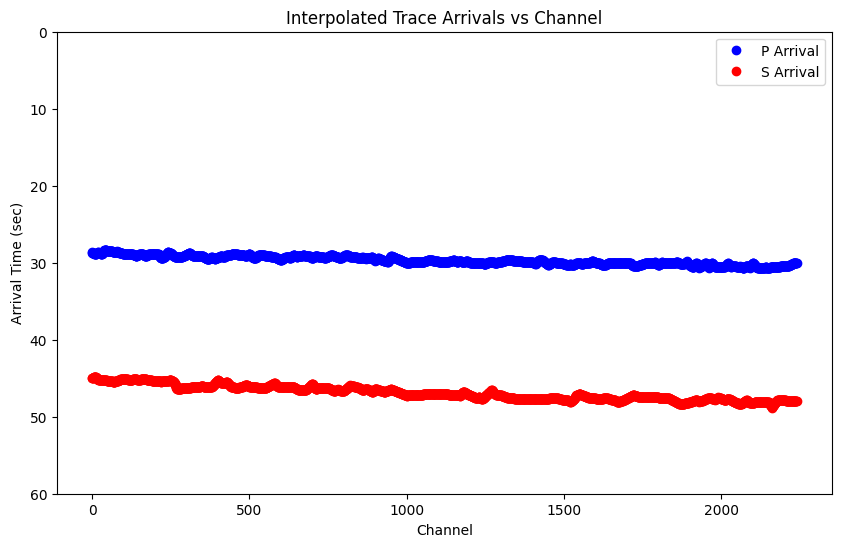

In [146]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(p_dataset['das_number'], p_dataset['trace_p_arrival_sec_interpolated2'], 'o', color='blue', label='P Arrival')
ax.plot(s_dataset['das_number'], s_dataset['trace_s_arrival_sec_interpolated2'], 'o', color='red', label='S Arrival')

ax.set_title('Interpolated Trace Arrivals vs Channel')
ax.set_xlabel('Channel')
ax.set_ylabel('Arrival Time (sec)')
ax.set_ylim(0, 60)
ax.legend()
# Invert y-axis if needed
ax.invert_yaxis()


#### File Creation

In [147]:
#create a 2D numpy array of p_array_6sec with dimensions (1500, 8530)
# Create a 2D numpy array of p_array_6sec with dimensions (1500, 8530)
#p_dataset["Sample#"] = p_dataset['trace_p_arrival_sec_interpolated2']*25
p_array_6sec = np.zeros((1500, 8530))

#convert the trace_p_arrival_sec_interpolated2 column to a numpy array and multiply by 25
p_dataset["Sample#"] = p_dataset['trace_p_arrival_sec_interpolated2']*25

#drop Nan values
p_dataset.dropna(subset=['Sample#', 'das_number'], inplace=True)

#match the sample# column and das_number columns to the p_array_6sec array with it (sample#, das_number) and assign 1 values to those points
for index, row in p_dataset.iterrows():
    sample_number = int(row['Sample#'])
    das_number = int(row['das_number'])
    if 0 <= sample_number < 1500 and 0 <= das_number < 8530:
        p_array_6sec[sample_number, das_number] = 1

#add 1 values each sample for 250 samples after the sample number for the s-wave 
for index, row in p_dataset.iterrows():
    sample_number = int(row['Sample#'])
    das_number = int(row['das_number'])
    if 0 <= sample_number < 1500 and 0 <= das_number < 8530:
        for i in range(1, 25 * p_arrival_mask + 1):
            if sample_number + i < 1500:
                p_array_6sec[sample_number + i, das_number] = 1

#save zeroes
#np.save('F:/DAS/'+str(p_arrival_mask)+'/p/p-wave_2023-12-30_22.35.57_UTC_'+str(p_arrival_mask)+'sec_filled.npy', p_array_6sec)

#save p_array_6sec as a csv file
#np.savetxt('F:/DAS/p-wave_2023-12-30_22.35.57_UTC.np', p_array_6sec, delimiter=',')


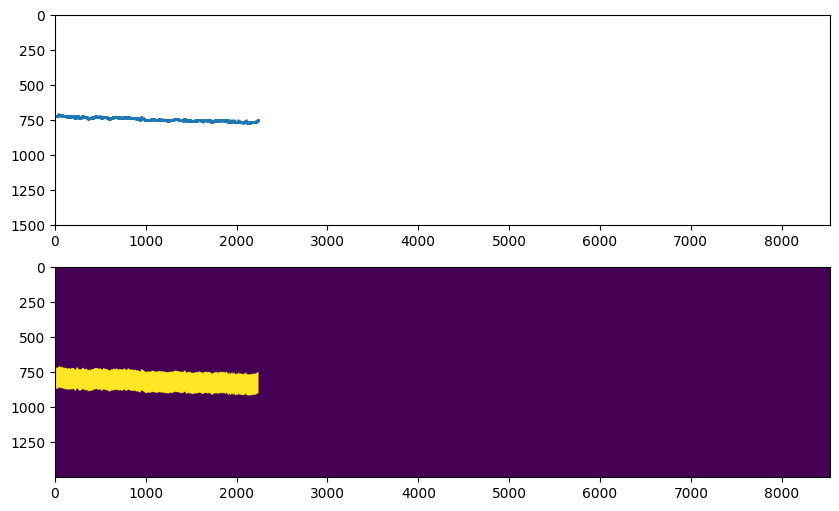

In [148]:
fig, axes= plt.subplots(2, 1, figsize=(10, 6))

axes[0].scatter(p_dataset['das_number'], p_dataset["Sample#"], s = 0.5)
axes[0].set_xlim(0, 8530)
axes[0].set_ylim(0, 1500)
axes[0].invert_yaxis()

axes[1].imshow(p_array_6sec, aspect='auto')

In [149]:
#create a 2D numpy array of s_array_6sec with dimensions (1500, 8530)
# Create a 2D numpy array of s_array_6sec with dimensions (1500, 8530)
#p_dataset["Sample#"] = p_dataset['trace_p_arrival_sec_interpolated2']*25
s_array_6sec = np.zeros((1500, 8530))

#convert the trace_p_arrival_sec_interpolated2 column to a numpy array and multiply by 25
s_dataset["Sample#"] = s_dataset['trace_s_arrival_sec_interpolated2']*25

#drop Nan values
s_dataset.dropna(subset=['Sample#', 'das_number'], inplace=True)

#match the sample# column and das_number columns to the s_array_6sec array with it (sample#, das_number) and assign 1 values to those points
for index, row in s_dataset.iterrows():
    sample_number = int(row['Sample#'])
    das_number = int(row['das_number'])
    if 0 <= sample_number < 1500 and 0 <= das_number < 8530:
        s_array_6sec[sample_number, das_number] = 1

#add 1 values each sample for 250 samples after the sample number for the s-wave 

for index, row in s_dataset.iterrows():
    sample_number = int(row['Sample#'])
    das_number = int(row['das_number'])
    if 0 <= sample_number < 1500 and 0 <= das_number < 8530:
        for i in range(1, 25 * s_arrival_mask + 1):
            if sample_number + i < 1500:
                s_array_6sec[sample_number + i, das_number] = 1

#save zeroes
#np.save('F:/DAS/'+str(s_arrival_mask)+'/s/s-wave_2023-12-30_22.35.57_UTC_'+str(s_arrival_mask)+'sec_filled.npy', s_array_6sec)

#save s_array_6sec as a csv file
#np.savetxt('F:/DAS/p-wave_2023-12-30_22.35.57_UTC.np', s_array_6sec, delimiter=',')


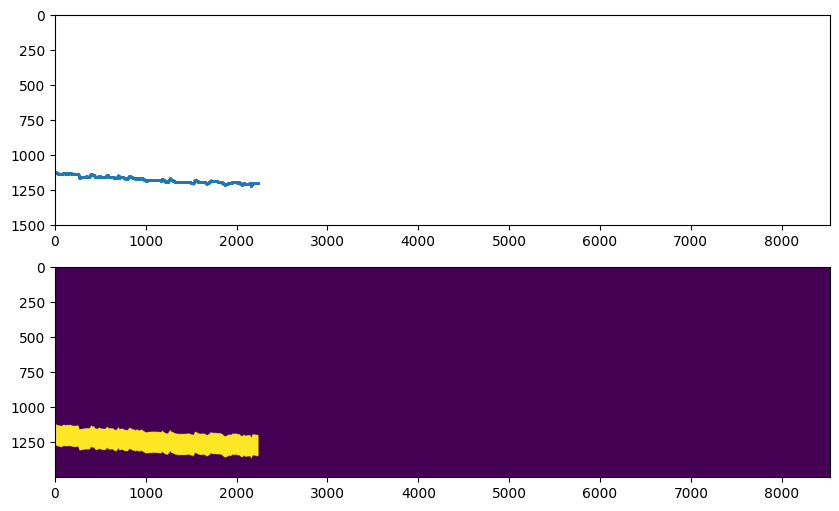

In [150]:
fig, axes= plt.subplots(2, 1, figsize=(10, 6))

axes[0].scatter(s_dataset['das_number'], s_dataset["Sample#"], s = 0.5)
axes[0].set_xlim(0, 8530)
axes[0].set_ylim(0, 1500)
axes[0].invert_yaxis()

axes[1].imshow(s_array_6sec, aspect='auto')

In [151]:
# #turn previous section into a for loop to iterate through all the unique trace_start_times

# for i in unique_trace_start_times_dropped:
#     if i.strip() == '':
#         print(f"Skipping invalid trace_start_time: '{i}'")
#         continue
    
#     # Define directory and filename
#     # Convert i into a string with format YYYYMMDD_HHMMSS
#     name = str(i).replace(" ", "_").replace(":", "_").replace("-", "_").replace(".", "_")
    
#     directory = "F:/DAS/pick_plots_interpolated_20250401"
#     filename = str(name) + ".png"

#     # Combine directory and filename
#     filepath = os.path.join(directory, filename)

#     # Select the specific row based on the index
#     data = grouped_df_dropped.loc[i]

#     # Select specific columns from the row
#     dropped_dataset = data[['trace_p_arrival_sec', 'trace_s_arrival_sec', 'das_number']]
#     p_dataset = dropped_dataset[['trace_p_arrival_sec','das_number']]
#     s_dataset = dropped_dataset[['trace_s_arrival_sec','das_number']]

#     #drop Nans
#     p_dataset.dropna(subset=['trace_p_arrival_sec', "das_number"], inplace = True)
#     s_dataset.dropna(subset=['trace_s_arrival_sec', "das_number"], inplace = True)
    
#     #convert das_number column to int
#     p_dataset['das_number'] = p_dataset['das_number'].astype(float)
#     s_dataset['das_number'] = s_dataset['das_number'].astype(float)
#     p_dataset['trace_p_arrival_sec'] = p_dataset['trace_p_arrival_sec'].astype(float)
#     s_dataset['trace_s_arrival_sec'] = s_dataset['trace_s_arrival_sec'].astype(float)

#     # Fit individual polynomials for p_dataset and s_dataset
#     p_coeffs_individual = np.polyfit(p_dataset['das_number'].values, p_dataset['trace_p_arrival_sec'].values, deg=1)
#     s_coeffs_individual = np.polyfit(s_dataset['das_number'].values, s_dataset['trace_s_arrival_sec'].values, deg=1)

#     # # Calculate the trends
#     p_trend_individual = np.polyval(p_coeffs_individual, pd.to_numeric(p_dataset['das_number']))
#     s_trend_individual = np.polyval(s_coeffs_individual, pd.to_numeric(s_dataset['das_number']))

#     #Detrend by subtracting the individual trends
#     p_dataset['trace_p_arrival_sec_detrended'] = p_dataset['trace_p_arrival_sec'] - p_trend_individual
#     s_dataset['trace_s_arrival_sec_detrended'] = s_dataset['trace_s_arrival_sec'] - s_trend_individual

#     #calculate 2 standard deviations from the mean for the trace_p_arrival_sec and trace_s_arrival_sec columns
#     p_dataset_mean = p_dataset['trace_p_arrival_sec_detrended'].mean()
#     p_dataset_std = p_dataset['trace_p_arrival_sec_detrended'].std()
#     p_dataset_2std = 2 * p_dataset_std

#     # do it for s_dataset
#     s_dataset_mean = s_dataset['trace_s_arrival_sec_detrended'].mean()
#     s_dataset_std = s_dataset['trace_s_arrival_sec_detrended'].std()
#     s_dataset_2std = 2 * s_dataset_std
    
#     #save values for index which are greater than 2 standard deviations from the mean for the trace_p_arrival_sec column
#     p_dataset_outliers = p_dataset[(p_dataset['trace_p_arrival_sec_detrended'].values > p_dataset_2std) | 
#                                    (p_dataset['trace_p_arrival_sec_detrended'].values < -p_dataset_2std)]

#     #replace p_dataset trace_p_arrival_sec and trace_p_arrival_sec_detrended with Nans for the das_number values that occur in p_dataset_outliers
#     p_dataset.loc[p_dataset_outliers.index, 'trace_p_arrival_sec'] = np.nan
#     p_dataset.loc[p_dataset_outliers.index, 'trace_p_arrival_sec_detrended'] = np.nan

#     # Save values for index which are greater than 2 standard deviations from the mean for the trace_s_arrival_sec column
#     s_dataset_outliers = s_dataset[(s_dataset['trace_s_arrival_sec_detrended'].values > s_dataset_2std) | 
#                                    (s_dataset['trace_s_arrival_sec_detrended'].values < -s_dataset_2std)]

#     # Replace s_dataset trace_s_arrival_sec and trace_s_arrival_sec_detrended with NaNs for the das_number values that occur in s_dataset_outliers
#     s_dataset.loc[s_dataset_outliers.index, 'trace_s_arrival_sec'] = np.nan
#     s_dataset.loc[s_dataset_outliers.index, 'trace_s_arrival_sec_detrended'] = np.nan

#     #interpolate the missing values from the p_outliers and s_outliers dataframes using the interpolate function
#     p_dataset['trace_p_arrival_sec_interpolated'] = p_dataset['trace_p_arrival_sec'].interpolate()
#     s_dataset['trace_s_arrival_sec_interpolated'] = s_dataset['trace_s_arrival_sec'].interpolate()

#     new_array = arange(1, 10000, 1)

#     # Create a DataFrame with all possible das_number values from new_array
#     full_range_df = pd.DataFrame({'das_number': new_array})

#     # Merge with p_dataset and s_dataset to include missing values
#     p_dataset = full_range_df.merge(p_dataset, on='das_number', how='left')
#     s_dataset = full_range_df.merge(s_dataset, on='das_number', how='left')

#     #interpolate again to fill the missing values based on trace_p_arrivaL_sec_interpolated
#     p_dataset['trace_p_arrival_sec_interpolated2'] = p_dataset['trace_p_arrival_sec_interpolated'].interpolate()

#     #interpolate again to fill the missing values based on trace_s_arrivaL_sec_interpolated
#     s_dataset['trace_s_arrival_sec_interpolated2'] = s_dataset['trace_s_arrival_sec_interpolated'].interpolate()

#     # Plot the interpolated values
#     plt.figure(figsize=(10, 6))
  
#     plt.plot(p_dataset['das_number'], p_dataset['trace_p_arrival_sec_interpolated2'], 'o', color='blue', label='P Arrival')
#     plt.plot(s_dataset['das_number'], s_dataset['trace_s_arrival_sec_interpolated2'], 'o', color='red', label='S Arrival')

#     plt.title(f'Interpolated Trace Arrivals vs Channel for {i}')
#     plt.xlabel('Channel')
#     plt.ylabel('Arrival Time (sec)')
#     plt.ylim(0, 60)
#     plt.legend()

#     # Set the number of ticks to 5
#     plt.gca().xaxis.set_major_locator(MaxNLocator(5))
#     plt.savefig(filepath)
#     plt.close()

### 1 sec 2023-12-30T22:35:57.2000000Z - cells below take the individual DAS file location + pick time to extract and make 2 numpy arrays based on where the pick is located

#### Background

In [152]:
# decide the amount of seconds you want to add to the mask after the arrival time for p and s waves

p_arrival_mask = 1
s_arrival_mask = 1

In [153]:
# Select the specific row based on the index
data_2023_12_30 = grouped_df_dropped.loc['2023-12-30T22:35:57.200000Z']

# Select specific columns from the row
dropped_dataset = data_2023_12_30[['trace_p_arrival_sec', 'trace_s_arrival_sec', 'das_number']]
p_dataset = dropped_dataset[['trace_p_arrival_sec','das_number']]
s_dataset = dropped_dataset[['trace_s_arrival_sec','das_number']]


In [154]:
p_dataset.dropna(subset=['trace_p_arrival_sec', "das_number"], inplace = True)
s_dataset.dropna(subset=['trace_s_arrival_sec', "das_number"], inplace = True)

C:\Users\alexa\AppData\Local\Temp\ipykernel_24260\751016926.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p_dataset.dropna(subset=['trace_p_arrival_sec', "das_number"], inplace = True)
C:\Users\alexa\AppData\Local\Temp\ipykernel_24260\751016926.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  s_dataset.dropna(subset=['trace_s_arrival_sec', "das_number"], inplace = True)


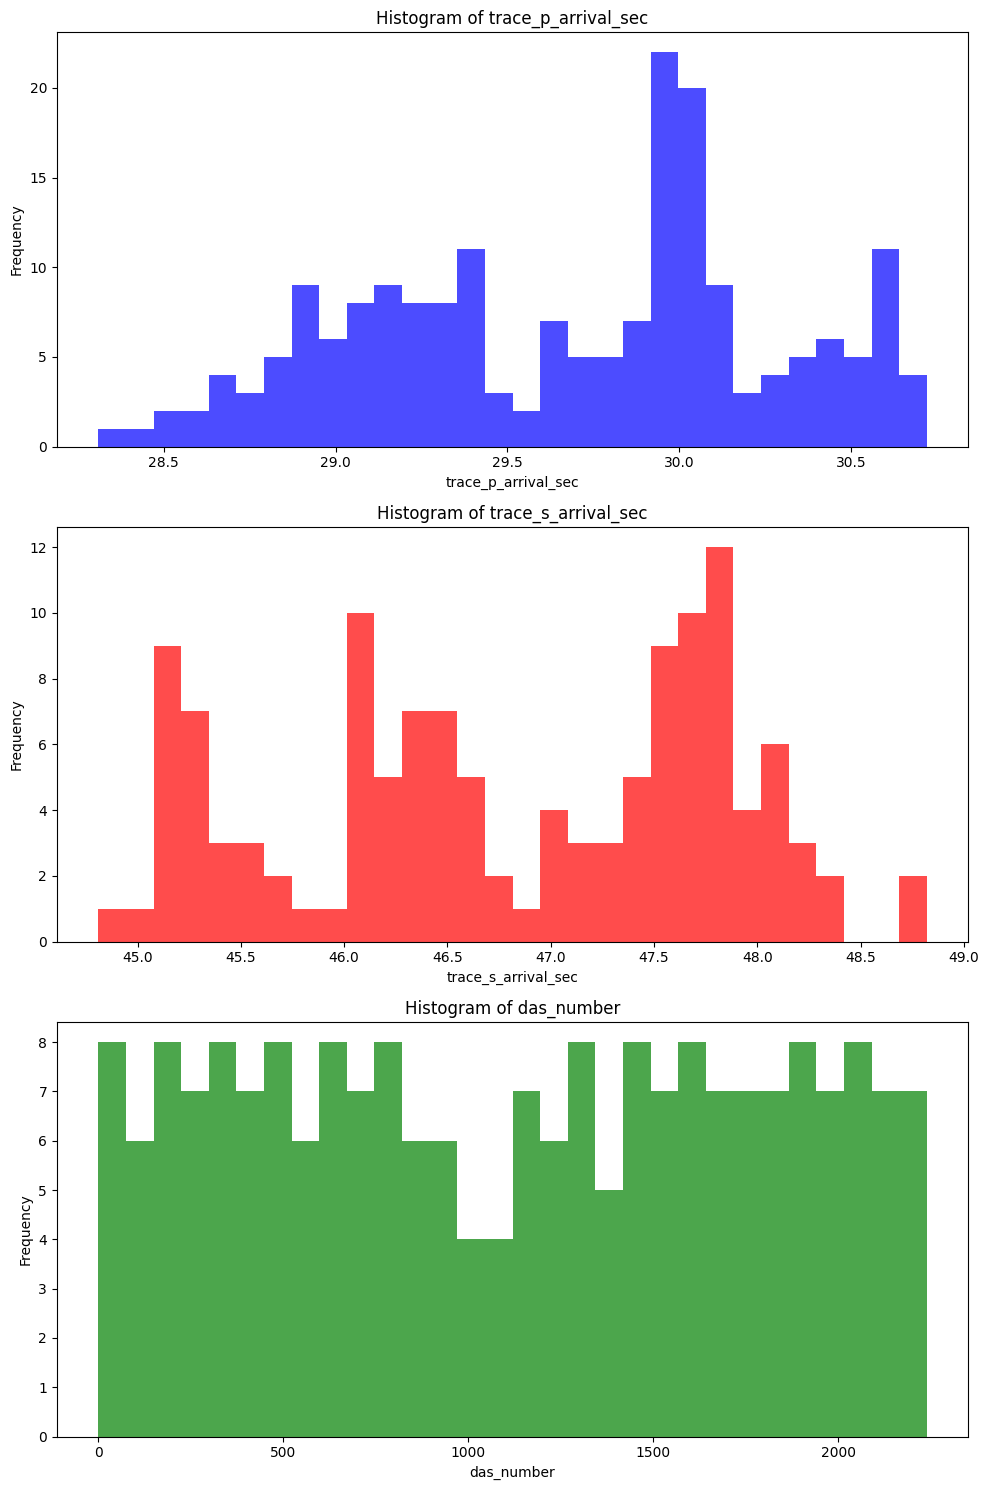

In [155]:
fig, axes = plt.subplots(3, 1, figsize=(10, 15))

# Histogram for trace_p_arrival_sec
axes[0].hist(pd.to_numeric(dropped_dataset['trace_p_arrival_sec'], errors='coerce').dropna(), bins=30, color='blue', alpha=0.7)
axes[0].set_title('Histogram of trace_p_arrival_sec')
axes[0].set_xlabel('trace_p_arrival_sec')
axes[0].set_ylabel('Frequency')

# Histogram for trace_s_arrival_sec
axes[1].hist(pd.to_numeric(dropped_dataset['trace_s_arrival_sec'], errors='coerce').dropna(), bins=30, color='red', alpha=0.7)
axes[1].set_title('Histogram of trace_s_arrival_sec')
axes[1].set_xlabel('trace_s_arrival_sec')
axes[1].set_ylabel('Frequency')

# Histogram for das_number
axes[2].hist(pd.to_numeric(dropped_dataset['das_number'], errors='coerce').dropna(), bins=30, color='green', alpha=0.7)
axes[2].set_title('Histogram of das_number')
axes[2].set_xlabel('das_number')
axes[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [156]:
# Was having issues later with interpolation so changing the data type to float
# convert das_number column to int
p_dataset['das_number'] = p_dataset['das_number'].astype(float)
s_dataset['das_number'] = s_dataset['das_number'].astype(float)
p_dataset['trace_p_arrival_sec'] = p_dataset['trace_p_arrival_sec'].astype(float)
s_dataset['trace_s_arrival_sec'] = s_dataset['trace_s_arrival_sec'].astype(float)



C:\Users\alexa\AppData\Local\Temp\ipykernel_24260\3263820701.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p_dataset['das_number'] = p_dataset['das_number'].astype(float)
C:\Users\alexa\AppData\Local\Temp\ipykernel_24260\3263820701.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  s_dataset['das_number'] = s_dataset['das_number'].astype(float)
C:\Users\alexa\AppData\Local\Temp\ipykernel_24260\3263820701.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.

In [157]:
# Dropping Nans in the p_dataset and s_dataset
p_dataset.dropna(subset=['trace_p_arrival_sec', "das_number"], inplace = True)
print(p_dataset["trace_p_arrival_sec"].isna())

1        False
96       False
191      False
286      False
381      False
         ...  
20711    False
20806    False
20996    False
21186    False
21281    False
Name: trace_p_arrival_sec, Length: 195, dtype: bool


C:\Users\alexa\AppData\Local\Temp\ipykernel_24260\2010603134.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p_dataset.dropna(subset=['trace_p_arrival_sec', "das_number"], inplace = True)


In [158]:
print(p_dataset["das_number"].dtype)
print(p_dataset["trace_p_arrival_sec"].dtype)
print(s_dataset["das_number"].dtype)
print(s_dataset["trace_s_arrival_sec"].dtype)


float64
float64
float64
float64


In [159]:
print(p_dataset["das_number"].values)
print(p_dataset["trace_p_arrival_sec"].values)
print(s_dataset["das_number"].values)
print(s_dataset["trace_s_arrival_sec"].values)


[   0.   10.   20.   30.   40.   50.   60.   70.   80.   90.  120.  130.
  140.  150.  160.  170.  180.  190.  210.  220.  230.  240.  250.  260.
  280.  290.  300.  310.  320.  330.  340.  350.  360.  370.  380.  390.
  400.  410.  420.  430.  440.  450.  460.  470.  480.  490.  500.  510.
  520.  530.  540.  550.  580.  590.  600.  610.  620.  630.  640.  650.
  670.  690.  700.  710.  720.  730.  740.  750.  760.  780.  790.  800.
  810.  820.  840.  850.  860.  870.  880.  890.  900.  910.  920.  940.
  950. 1000. 1010. 1020. 1050. 1070. 1090. 1100. 1130. 1140. 1150. 1160.
 1170. 1180. 1190. 1200. 1230. 1240. 1250. 1260. 1270. 1280. 1290. 1300.
 1320. 1330. 1340. 1360. 1370. 1380. 1400. 1410. 1420. 1430. 1440. 1450.
 1460. 1470. 1480. 1490. 1510. 1520. 1530. 1540. 1550. 1560. 1570. 1580.
 1590. 1600. 1610. 1620. 1630. 1640. 1650. 1660. 1670. 1680. 1690. 1700.
 1710. 1720. 1730. 1740. 1750. 1760. 1780. 1790. 1800. 1810. 1820. 1830.
 1840. 1850. 1860. 1870. 1880. 1890. 1900. 1910. 19

In [160]:
# Fit individual polynomials for p_dataset and s_dataset
p_coeffs_individual = np.polyfit(p_dataset['das_number'].values, p_dataset['trace_p_arrival_sec'].values, deg=1)
s_coeffs_individual = np.polyfit(s_dataset['das_number'].values, s_dataset['trace_s_arrival_sec'].values, deg=1)

# # Calculate the trends
p_trend_individual = np.polyval(p_coeffs_individual, pd.to_numeric(p_dataset['das_number']))
s_trend_individual = np.polyval(s_coeffs_individual, pd.to_numeric(s_dataset['das_number']))

# # Detrend by subtracting the individual trends
p_dataset['trace_p_arrival_sec_detrended'] = p_dataset['trace_p_arrival_sec'] - p_trend_individual
s_dataset['trace_s_arrival_sec_detrended'] = s_dataset['trace_s_arrival_sec'] - s_trend_individual



C:\Users\alexa\AppData\Local\Temp\ipykernel_24260\1877243647.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p_dataset['trace_p_arrival_sec_detrended'] = p_dataset['trace_p_arrival_sec'] - p_trend_individual
C:\Users\alexa\AppData\Local\Temp\ipykernel_24260\1877243647.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  s_dataset['trace_s_arrival_sec_detrended'] = s_dataset['trace_s_arrival_sec'] - s_trend_individual


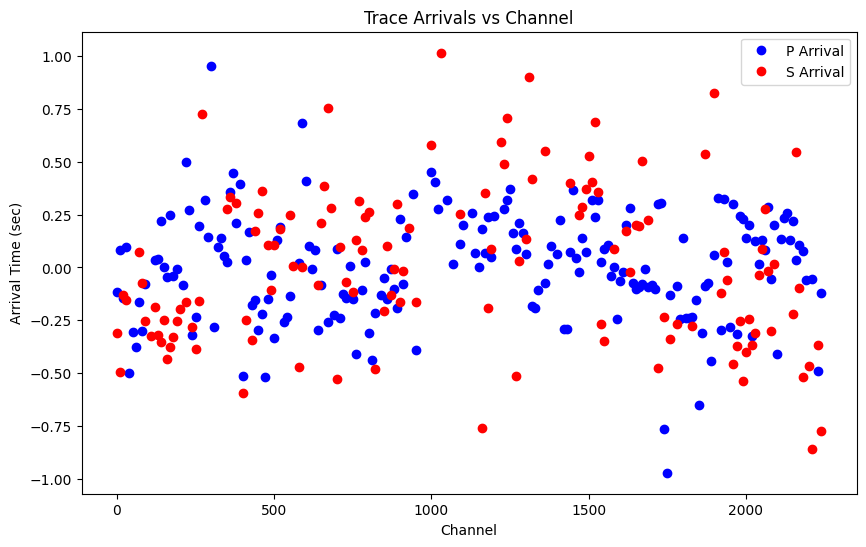

In [161]:
#plot to see detrended data and the distribution of the data compared between the p and s arrivals
plt.figure(figsize=(10, 6))
  

plt.plot(p_dataset['das_number'], p_dataset['trace_p_arrival_sec_detrended'], 'o', color='blue', label='P Arrival')
plt.plot(s_dataset['das_number'], s_dataset['trace_s_arrival_sec_detrended'], 'o', color='red', label='S Arrival')

plt.title(f'Trace Arrivals vs Channel')
plt.xlabel('Channel')
plt.ylabel('Arrival Time (sec)')
plt.legend()
# Set the number of ticks to 5
plt.gca().xaxis.set_major_locator(MaxNLocator(5))

Text(0, 0.5, 'Frequency')

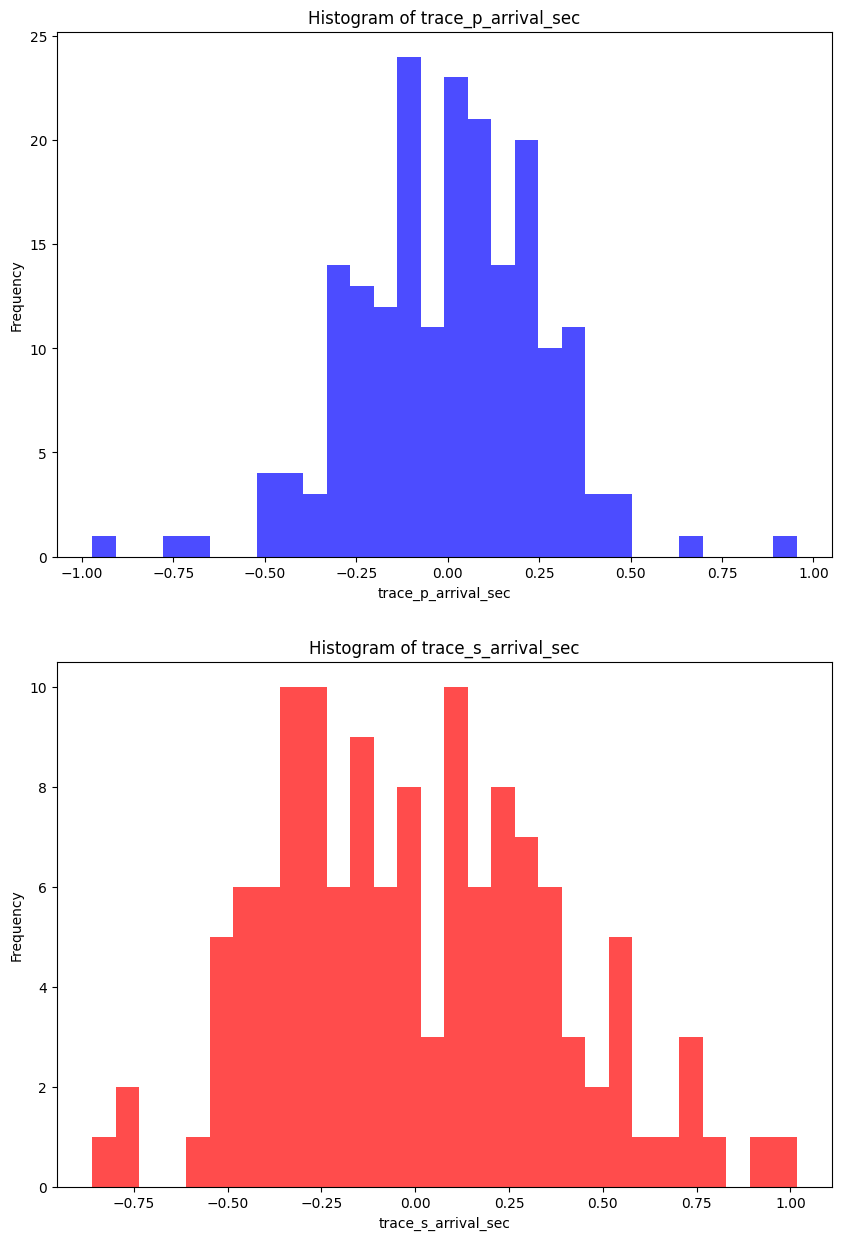

In [162]:
fig, axes = plt.subplots(2, 1, figsize=(10, 15))

# Histogram for trace_p_arrival_sec
axes[0].hist(pd.to_numeric(p_dataset['trace_p_arrival_sec_detrended'], errors='coerce').dropna(), bins=30, color='blue', alpha=0.7)
axes[0].set_title('Histogram of trace_p_arrival_sec')
axes[0].set_xlabel('trace_p_arrival_sec')
axes[0].set_ylabel('Frequency')

# Histogram for trace_s_arrival_sec
axes[1].hist(pd.to_numeric(s_dataset['trace_s_arrival_sec_detrended'], errors='coerce').dropna(), bins=30, color='red', alpha=0.7)
axes[1].set_title('Histogram of trace_s_arrival_sec')
axes[1].set_xlabel('trace_s_arrival_sec')
axes[1].set_ylabel('Frequency')


In [163]:
#calculate 2 standard deviations from the mean for the trace_p_arrival_sec and trace_s_arrival_sec columns
p_dataset_mean = p_dataset['trace_p_arrival_sec_detrended'].mean()
p_dataset_std = p_dataset['trace_p_arrival_sec_detrended'].std()
p_dataset_2std = 2 * p_dataset_std

print(p_dataset_mean)
print(p_dataset_std)
print(p_dataset_2std)



2.022313940240285e-15
0.25571951595899595
0.5114390319179919


In [164]:
# do it for s_dataset
s_dataset_mean = s_dataset['trace_s_arrival_sec_detrended'].mean()
s_dataset_std = s_dataset['trace_s_arrival_sec_detrended'].std()
s_dataset_2std = 2 * s_dataset_std

print(s_dataset_mean)
print(s_dataset_std)
print(s_dataset_2std)

1.0380585280245214e-14
0.3729898592187784
0.7459797184375568


In [165]:
#save values for index which are greater than 2 standard deviations from the mean for the trace_p_arrival_sec column
p_dataset_outliers = p_dataset[(p_dataset['trace_p_arrival_sec_detrended'].values > p_dataset_2std) | 
                               (p_dataset['trace_p_arrival_sec_detrended'].values < -p_dataset_2std)]

p_dataset_outliers

#replace p_dataset trace_p_arrival_sec and trace_p_arrival_sec_detrended with Nans for the das_number values that occur in p_dataset_outliers
p_dataset.loc[p_dataset_outliers.index, 'trace_p_arrival_sec'] = np.nan
p_dataset.loc[p_dataset_outliers.index, 'trace_p_arrival_sec_detrended'] = np.nan


#find the columns that are Nans
p_dataset[p_dataset['trace_p_arrival_sec'].isna()]

,trace_p_arrival_sec,das_number,trace_p_arrival_sec_detrended
2851,NaN,300.0,NaN
3801,NaN,400.0,NaN
4466,NaN,470.0,NaN
5606,NaN,590.0,NaN
16531,NaN,1740.0,NaN
16626,NaN,1750.0,NaN
17576,NaN,1850.0,NaN


In [166]:
# Save values for index which are greater than 2 standard deviations from the mean for the trace_s_arrival_sec column
s_dataset_outliers = s_dataset[(s_dataset['trace_s_arrival_sec_detrended'].values > s_dataset_2std) | 
                               (s_dataset['trace_s_arrival_sec_detrended'].values < -s_dataset_2std)]

s_dataset_outliers

# Replace s_dataset trace_s_arrival_sec and trace_s_arrival_sec_detrended with NaNs for the das_number values that occur in s_dataset_outliers
s_dataset.loc[s_dataset_outliers.index, 'trace_s_arrival_sec'] = np.nan
s_dataset.loc[s_dataset_outliers.index, 'trace_s_arrival_sec_detrended'] = np.nan

# Find the columns that are NaNs
s_dataset[s_dataset['trace_s_arrival_sec'].isna()]


,trace_s_arrival_sec,das_number,trace_s_arrival_sec_detrended
6366,NaN,670.0,NaN
9786,NaN,1030.0,NaN
11021,NaN,1160.0,NaN
12446,NaN,1310.0,NaN
18051,NaN,1900.0,NaN
20996,NaN,2210.0,NaN
21281,NaN,2240.0,NaN


Text(0, 0.5, 'Frequency')

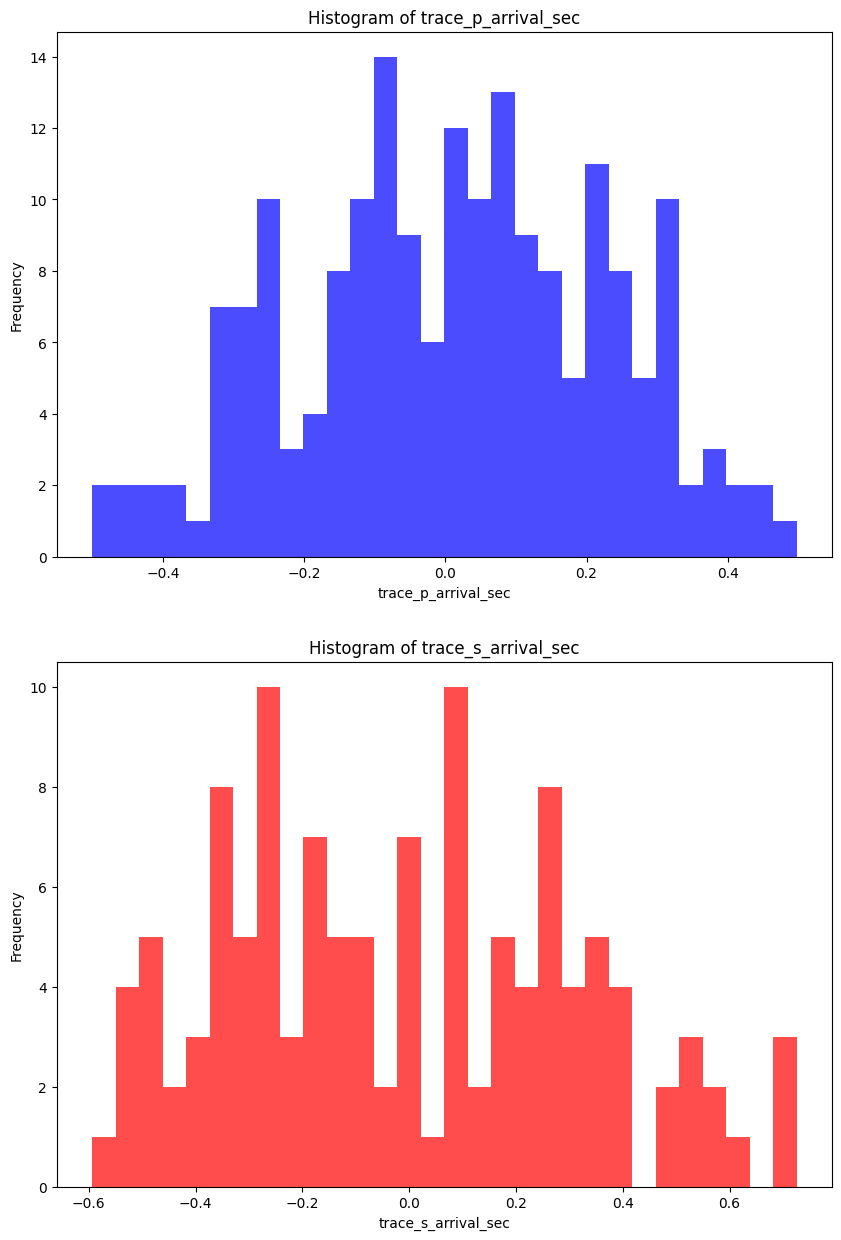

In [167]:
fig, axes = plt.subplots(2, 1, figsize=(10, 15))

# Histogram for trace_p_arrival_sec
axes[0].hist(pd.to_numeric(p_dataset['trace_p_arrival_sec_detrended'], errors='coerce').dropna(), bins=30, color='blue', alpha=0.7)
axes[0].set_title('Histogram of trace_p_arrival_sec')
axes[0].set_xlabel('trace_p_arrival_sec')
axes[0].set_ylabel('Frequency')

# Histogram for trace_s_arrival_sec
axes[1].hist(pd.to_numeric(s_dataset['trace_s_arrival_sec_detrended'], errors='coerce').dropna(), bins=30, color='red', alpha=0.7)
axes[1].set_title('Histogram of trace_s_arrival_sec')
axes[1].set_xlabel('trace_s_arrival_sec')
axes[1].set_ylabel('Frequency')

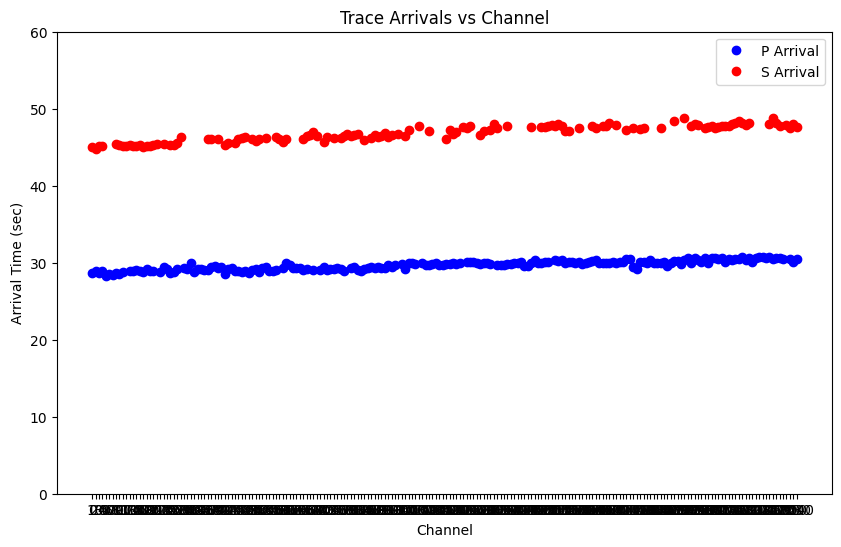

In [168]:
#original
plt.figure(figsize=(10, 6))


plt.plot(dropped_dataset['das_number'], dropped_dataset['trace_p_arrival_sec'], 'o', color='blue', label='P Arrival')
plt.plot(dropped_dataset['das_number'], dropped_dataset['trace_s_arrival_sec'], 'o', color='red', label='S Arrival')

plt.title(f'Trace Arrivals vs Channel')
plt.xlabel('Channel')
plt.ylabel('Arrival Time (sec)')
plt.ylim(0, 60)
plt.legend()

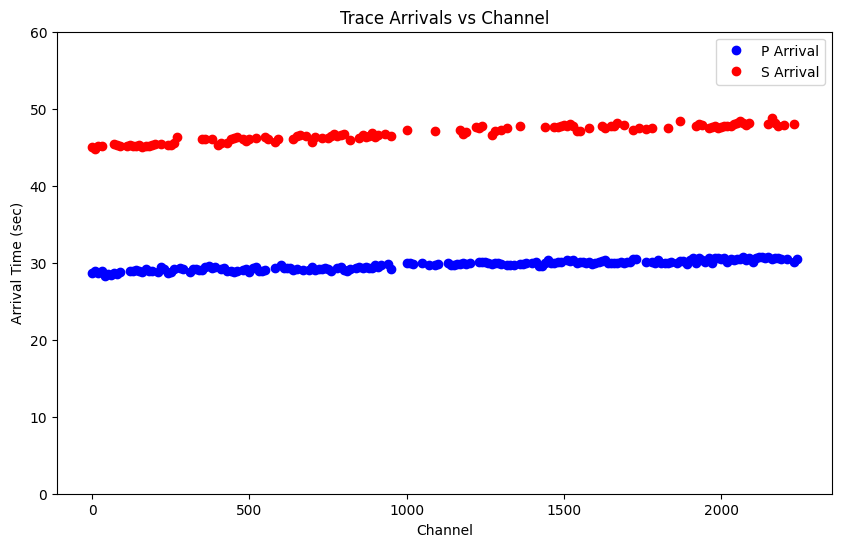

In [169]:
plt.figure(figsize=(10, 6))
  

plt.plot(p_dataset['das_number'], p_dataset['trace_p_arrival_sec'], 'o', color='blue', label='P Arrival')
plt.plot(s_dataset['das_number'], s_dataset['trace_s_arrival_sec'], 'o', color='red', label='S Arrival')

plt.title(f'Trace Arrivals vs Channel')
plt.xlabel('Channel')
plt.ylabel('Arrival Time (sec)')
plt.ylim(0, 60)
plt.legend()

In [170]:
#interpolate the missing values from the p_outliers and s_outliers dataframes using the interpolate function
p_dataset['trace_p_arrival_sec_interpolated'] = p_dataset['trace_p_arrival_sec'].interpolate()
s_dataset['trace_s_arrival_sec_interpolated'] = s_dataset['trace_s_arrival_sec'].interpolate()

s_dataset


C:\Users\alexa\AppData\Local\Temp\ipykernel_24260\3394753993.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p_dataset['trace_p_arrival_sec_interpolated'] = p_dataset['trace_p_arrival_sec'].interpolate()
C:\Users\alexa\AppData\Local\Temp\ipykernel_24260\3394753993.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  s_dataset['trace_s_arrival_sec_interpolated'] = s_dataset['trace_s_arrival_sec'].interpolate()


,trace_s_arrival_sec,das_number,trace_s_arrival_sec_detrended,trace_s_arrival_sec_interpolated
1,44.980000,0.0,-0.311748,44.980000
96,44.810001,10.0,-0.495546,44.810001
191,45.189999,20.0,-0.129347,45.189999
286,45.180000,30.0,-0.153145,45.180000
666,45.459999,70.0,0.071656,45.459999
...,...,...,...,...
20711,47.779999,2180.0,-0.519982,47.779999
20901,47.860001,2200.0,-0.467579,47.860001
20996,NaN,2210.0,NaN,47.930000
21186,48.000000,2230.0,-0.368977,48.000000


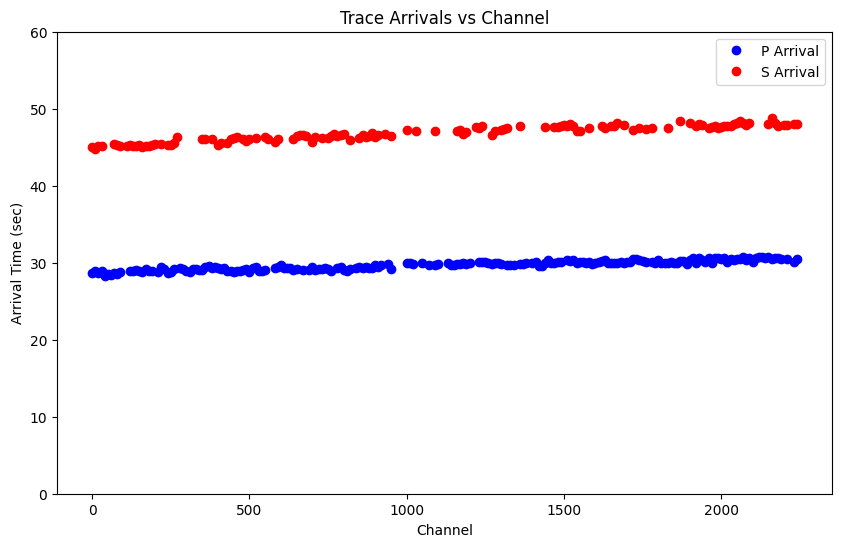

In [171]:
plt.figure(figsize=(10, 6))
  

plt.plot(p_dataset['das_number'], p_dataset['trace_p_arrival_sec_interpolated'], 'o', color='blue', label='P Arrival')
plt.plot(s_dataset['das_number'], s_dataset['trace_s_arrival_sec_interpolated'], 'o', color='red', label='S Arrival')

plt.title(f'Trace Arrivals vs Channel')
plt.xlabel('Channel')
plt.ylabel('Arrival Time (sec)')
plt.ylim(0, 60)
plt.legend()

#### Interpolation 2

In [172]:
#find min and max das_number for p_dataset and s_dataset
p_dataset_min = p_dataset['das_number'].min()
p_dataset_max = p_dataset['das_number'].max()
s_dataset_min = s_dataset['das_number'].min()
s_dataset_max = s_dataset['das_number'].max()

print(f"p_dataset das_number min: {p_dataset_min}, max: {p_dataset_max}")
print(f"s_dataset das_number min: {s_dataset_min}, max: {s_dataset_max}")

p_dataset das_number min: 0.0, max: 2240.0
s_dataset das_number min: 0.0, max: 2240.0


In [173]:
from numpy import arange

new_array = arange(0, 2240, 1)
new_array


array([   0,    1,    2, ..., 2237, 2238, 2239])

In [174]:
# Create a DataFrame with all possible das_number values from new_array
full_range_df = pd.DataFrame({'das_number': new_array})

# Merge with p_dataset and s_dataset to include missing values
p_dataset = full_range_df.merge(p_dataset, on='das_number', how='left')
s_dataset = full_range_df.merge(s_dataset, on='das_number', how='left')

#interpolate again to fill the missing values based on trace_p_arrivaL_sec_interpolated
p_dataset['trace_p_arrival_sec_interpolated2'] = p_dataset['trace_p_arrival_sec_interpolated'].interpolate()
p_dataset

#interpolate again to fill the missing values based on trace_s_arrivaL_sec_interpolated
s_dataset['trace_s_arrival_sec_interpolated2'] = s_dataset['trace_s_arrival_sec_interpolated'].interpolate()
#s_dataset


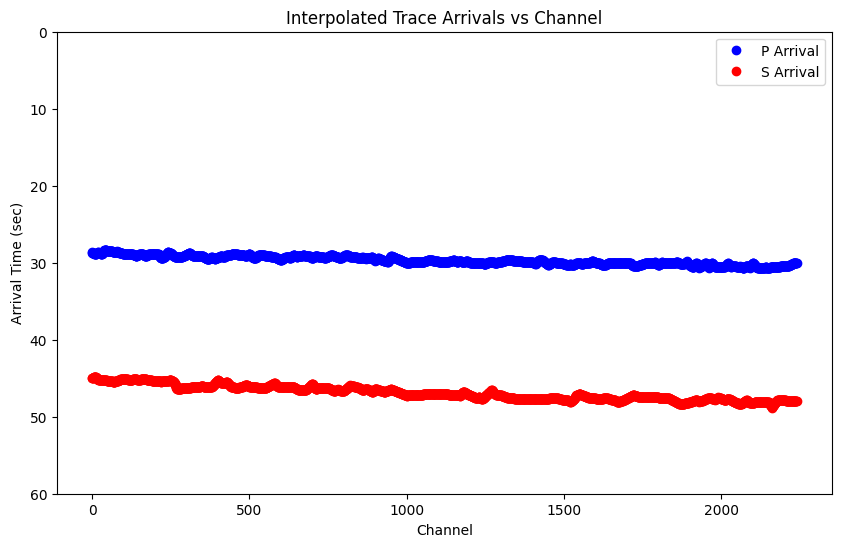

In [175]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(p_dataset['das_number'], p_dataset['trace_p_arrival_sec_interpolated2'], 'o', color='blue', label='P Arrival')
ax.plot(s_dataset['das_number'], s_dataset['trace_s_arrival_sec_interpolated2'], 'o', color='red', label='S Arrival')

ax.set_title('Interpolated Trace Arrivals vs Channel')
ax.set_xlabel('Channel')
ax.set_ylabel('Arrival Time (sec)')
ax.set_ylim(0, 60)
ax.legend()
# Invert y-axis if needed
ax.invert_yaxis()


#### File Creation

In [176]:
#create a 2D numpy array of p_array_1sec with dimensions (1500, 8530)
# Create a 2D numpy array of p_array_1sec with dimensions (1500, 8530)
#p_dataset["Sample#"] = p_dataset['trace_p_arrival_sec_interpolated2']*25
p_array_1sec = np.zeros((1500, 8530))

#convert the trace_p_arrival_sec_interpolated2 column to a numpy array and multiply by 25
p_dataset["Sample#"] = p_dataset['trace_p_arrival_sec_interpolated2']*25

#drop Nan values
p_dataset.dropna(subset=['Sample#', 'das_number'], inplace=True)

#match the sample# column and das_number columns to the p_array_1sec array with it (sample#, das_number) and assign 1 values to those points
for index, row in p_dataset.iterrows():
    sample_number = int(row['Sample#'])
    das_number = int(row['das_number'])
    if 0 <= sample_number < 1500 and 0 <= das_number < 8530:
        p_array_1sec[sample_number, das_number] = 1

#add 1 values each sample for 250 samples after the sample number for the s-wave 
for index, row in p_dataset.iterrows():
    sample_number = int(row['Sample#'])
    das_number = int(row['das_number'])
    if 0 <= sample_number < 1500 and 0 <= das_number < 8530:
        for i in range(1, 25 * p_arrival_mask + 1):
            if sample_number + i < 1500:
                p_array_1sec[sample_number + i, das_number] = 1

#save zeroes
#np.save('F:/DAS/'+str(p_arrival_mask)+'/p/p-wave_2023-12-30_22.35.57_UTC_'+str(p_arrival_mask)+'sec_filled.npy', p_array_1sec)

#save p_array_1sec as a csv file
#np.savetxt('F:/DAS/p-wave_2023-12-30_22.35.57_UTC.np', p_array_1sec, delimiter=',')


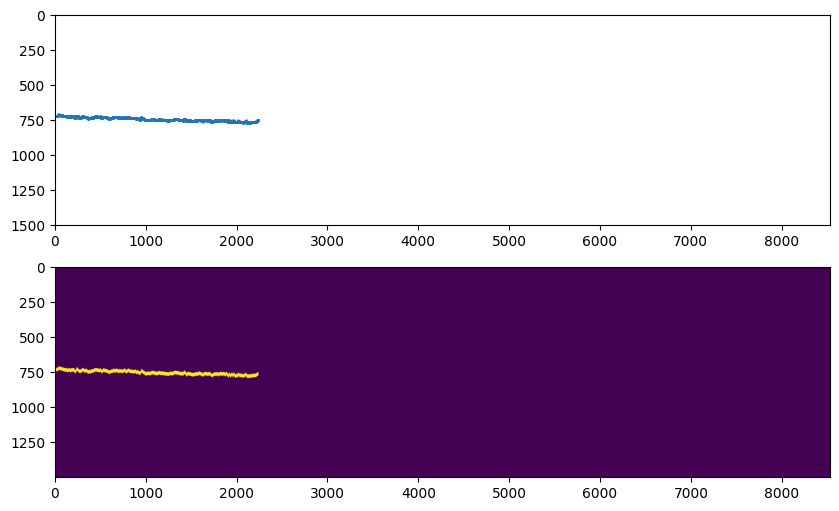

In [177]:
fig, axes= plt.subplots(2, 1, figsize=(10, 6))

axes[0].scatter(p_dataset['das_number'], p_dataset["Sample#"], s = 0.5)
axes[0].set_xlim(0, 8530)
axes[0].set_ylim(0, 1500)
axes[0].invert_yaxis()

axes[1].imshow(p_array_1sec, aspect='auto')



In [178]:
#create a 2D numpy array of s_array_1sec with dimensions (1500, 8530)
# Create a 2D numpy array of s_array_1sec with dimensions (1500, 8530)
#p_dataset["Sample#"] = p_dataset['trace_p_arrival_sec_interpolated2']*25
s_array_1sec = np.zeros((1500, 8530))

#convert the trace_p_arrival_sec_interpolated2 column to a numpy array and multiply by 25
s_dataset["Sample#"] = s_dataset['trace_s_arrival_sec_interpolated2']*25

#drop Nan values
s_dataset.dropna(subset=['Sample#', 'das_number'], inplace=True)

#match the sample# column and das_number columns to the s_array_1sec array with it (sample#, das_number) and assign 1 values to those points
for index, row in s_dataset.iterrows():
    sample_number = int(row['Sample#'])
    das_number = int(row['das_number'])
    if 0 <= sample_number < 1500 and 0 <= das_number < 8530:
        s_array_1sec[sample_number, das_number] = 1

#add 1 values each sample for 250 samples after the sample number for the s-wave 

for index, row in s_dataset.iterrows():
    sample_number = int(row['Sample#'])
    das_number = int(row['das_number'])
    if 0 <= sample_number < 1500 and 0 <= das_number < 8530:
        for i in range(1, 25 * s_arrival_mask + 1):
            if sample_number + i < 1500:
                s_array_1sec[sample_number + i, das_number] = 1

#save zeroes
#np.save('F:/DAS/'+str(s_arrival_mask)+'/s/s-wave_2023-12-30_22.35.57_UTC_'+str(s_arrival_mask)+'sec_filled.npy', s_array_1sec)

#save s_array_1sec as a csv file
#np.savetxt('F:/DAS/p-wave_2023-12-30_22.35.57_UTC.np', s_array_1sec, delimiter=',')


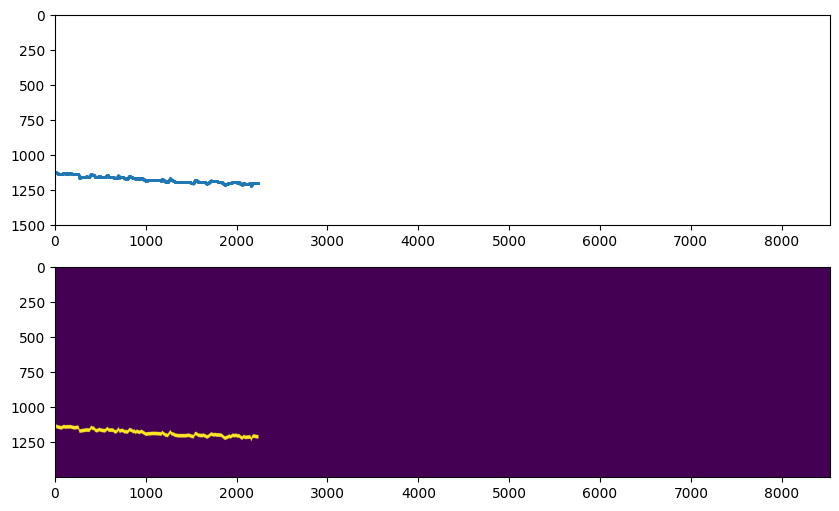

In [179]:
fig, axes= plt.subplots(2, 1, figsize=(10, 6))

axes[0].scatter(s_dataset['das_number'], s_dataset["Sample#"], s = 0.5)
axes[0].set_xlim(0, 8530)
axes[0].set_ylim(0, 1500)
axes[0].invert_yaxis()

axes[1].imshow(s_array_1sec, aspect='auto')

In [180]:
# #turn previous section into a for loop to iterate through all the unique trace_start_times

# for i in unique_trace_start_times_dropped:
#     if i.strip() == '':
#         print(f"Skipping invalid trace_start_time: '{i}'")
#         continue
    
#     # Define directory and filename
#     # Convert i into a string with format YYYYMMDD_HHMMSS
#     name = str(i).replace(" ", "_").replace(":", "_").replace("-", "_").replace(".", "_")
    
#     directory = "F:/DAS/pick_plots_interpolated_20250401"
#     filename = str(name) + ".png"

#     # Combine directory and filename
#     filepath = os.path.join(directory, filename)

#     # Select the specific row based on the index
#     data = grouped_df_dropped.loc[i]

#     # Select specific columns from the row
#     dropped_dataset = data[['trace_p_arrival_sec', 'trace_s_arrival_sec', 'das_number']]
#     p_dataset = dropped_dataset[['trace_p_arrival_sec','das_number']]
#     s_dataset = dropped_dataset[['trace_s_arrival_sec','das_number']]

#     #drop Nans
#     p_dataset.dropna(subset=['trace_p_arrival_sec', "das_number"], inplace = True)
#     s_dataset.dropna(subset=['trace_s_arrival_sec', "das_number"], inplace = True)
    
#     #convert das_number column to int
#     p_dataset['das_number'] = p_dataset['das_number'].astype(float)
#     s_dataset['das_number'] = s_dataset['das_number'].astype(float)
#     p_dataset['trace_p_arrival_sec'] = p_dataset['trace_p_arrival_sec'].astype(float)
#     s_dataset['trace_s_arrival_sec'] = s_dataset['trace_s_arrival_sec'].astype(float)

#     # Fit individual polynomials for p_dataset and s_dataset
#     p_coeffs_individual = np.polyfit(p_dataset['das_number'].values, p_dataset['trace_p_arrival_sec'].values, deg=1)
#     s_coeffs_individual = np.polyfit(s_dataset['das_number'].values, s_dataset['trace_s_arrival_sec'].values, deg=1)

#     # # Calculate the trends
#     p_trend_individual = np.polyval(p_coeffs_individual, pd.to_numeric(p_dataset['das_number']))
#     s_trend_individual = np.polyval(s_coeffs_individual, pd.to_numeric(s_dataset['das_number']))

#     #Detrend by subtracting the individual trends
#     p_dataset['trace_p_arrival_sec_detrended'] = p_dataset['trace_p_arrival_sec'] - p_trend_individual
#     s_dataset['trace_s_arrival_sec_detrended'] = s_dataset['trace_s_arrival_sec'] - s_trend_individual

#     #calculate 2 standard deviations from the mean for the trace_p_arrival_sec and trace_s_arrival_sec columns
#     p_dataset_mean = p_dataset['trace_p_arrival_sec_detrended'].mean()
#     p_dataset_std = p_dataset['trace_p_arrival_sec_detrended'].std()
#     p_dataset_2std = 2 * p_dataset_std

#     # do it for s_dataset
#     s_dataset_mean = s_dataset['trace_s_arrival_sec_detrended'].mean()
#     s_dataset_std = s_dataset['trace_s_arrival_sec_detrended'].std()
#     s_dataset_2std = 2 * s_dataset_std
    
#     #save values for index which are greater than 2 standard deviations from the mean for the trace_p_arrival_sec column
#     p_dataset_outliers = p_dataset[(p_dataset['trace_p_arrival_sec_detrended'].values > p_dataset_2std) | 
#                                    (p_dataset['trace_p_arrival_sec_detrended'].values < -p_dataset_2std)]

#     #replace p_dataset trace_p_arrival_sec and trace_p_arrival_sec_detrended with Nans for the das_number values that occur in p_dataset_outliers
#     p_dataset.loc[p_dataset_outliers.index, 'trace_p_arrival_sec'] = np.nan
#     p_dataset.loc[p_dataset_outliers.index, 'trace_p_arrival_sec_detrended'] = np.nan

#     # Save values for index which are greater than 2 standard deviations from the mean for the trace_s_arrival_sec column
#     s_dataset_outliers = s_dataset[(s_dataset['trace_s_arrival_sec_detrended'].values > s_dataset_2std) | 
#                                    (s_dataset['trace_s_arrival_sec_detrended'].values < -s_dataset_2std)]

#     # Replace s_dataset trace_s_arrival_sec and trace_s_arrival_sec_detrended with NaNs for the das_number values that occur in s_dataset_outliers
#     s_dataset.loc[s_dataset_outliers.index, 'trace_s_arrival_sec'] = np.nan
#     s_dataset.loc[s_dataset_outliers.index, 'trace_s_arrival_sec_detrended'] = np.nan

#     #interpolate the missing values from the p_outliers and s_outliers dataframes using the interpolate function
#     p_dataset['trace_p_arrival_sec_interpolated'] = p_dataset['trace_p_arrival_sec'].interpolate()
#     s_dataset['trace_s_arrival_sec_interpolated'] = s_dataset['trace_s_arrival_sec'].interpolate()

#     new_array = arange(1, 10000, 1)

#     # Create a DataFrame with all possible das_number values from new_array
#     full_range_df = pd.DataFrame({'das_number': new_array})

#     # Merge with p_dataset and s_dataset to include missing values
#     p_dataset = full_range_df.merge(p_dataset, on='das_number', how='left')
#     s_dataset = full_range_df.merge(s_dataset, on='das_number', how='left')

#     #interpolate again to fill the missing values based on trace_p_arrivaL_sec_interpolated
#     p_dataset['trace_p_arrival_sec_interpolated2'] = p_dataset['trace_p_arrival_sec_interpolated'].interpolate()

#     #interpolate again to fill the missing values based on trace_s_arrivaL_sec_interpolated
#     s_dataset['trace_s_arrival_sec_interpolated2'] = s_dataset['trace_s_arrival_sec_interpolated'].interpolate()

#     # Plot the interpolated values
#     plt.figure(figsize=(10, 6))
  
#     plt.plot(p_dataset['das_number'], p_dataset['trace_p_arrival_sec_interpolated2'], 'o', color='blue', label='P Arrival')
#     plt.plot(s_dataset['das_number'], s_dataset['trace_s_arrival_sec_interpolated2'], 'o', color='red', label='S Arrival')

#     plt.title(f'Interpolated Trace Arrivals vs Channel for {i}')
#     plt.xlabel('Channel')
#     plt.ylabel('Arrival Time (sec)')
#     plt.ylim(0, 60)
#     plt.legend()

#     # Set the number of ticks to 5
#     plt.gca().xaxis.set_major_locator(MaxNLocator(5))
#     plt.savefig(filepath)
#     plt.close()

# Plotting

In [183]:
# filepath for DAS raw data file
das = "F:\GitHub_files\FM_Segmentation_DAS\src\data\decimator2_2023-12-30_22.35.57_UTC.h5"
#filepath for DAS raw data file on SSH
#das = "/1-fnp/petasaur/p-jbod1/cidas/incoming/KKFL-S_FIberA_25Hz/decimator2_2023-12-30_22.35.57_UTC.h5"


In [186]:
# Load the data for das
das_load = h5py.File(das, 'r')
das_data = das_load['Acquisition/Raw[0]/RawData'][:] 
das_time = das_load['Acquisition/Raw[0]/RawDataTime'][:]
das_count = das_load['Acquisition/Raw[0]/RawDataSampleCount'][:]

In [ ]:
sampling_rate = 25 # hz

def highpass_filter(data, cutoff, fs, order=5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    y = filtfilt(b, a, data, axis=0)
    return y

# Apply high-pass filter to the data
cutoff_frequency = 1  # 1 Hz
#filtered_data = highpass_filter(data, cutoff_frequency, sampling_rate)

In [ ]:
# Apply high-pass filter to the data
filtered_data = highpass_filter(das_data, cutoff_frequency, sampling_rate)

#Normalize the filter
#ed data to the range [0, 255]
normalized_data = (filtered_data - np.min(filtered_data)) / (np.max(filtered_data) - np.min(filtered_data)) * 255
#Standardization (zero mean, unit variance)
array_standardized = (filtered_data - np.mean(filtered_data)) / np.std(filtered_data)

# Create a figure and axis without borders or extra padding

dmax = np.max(np.abs(array_standardized))

fig, ax = plt.subplots(3, 1, figsize=(15, 8))

ax[0].imshow(array_standardized.T, aspect='auto', cmap='seismic', vmin=-dmax/10, vmax=dmax/10)
ax[0].set_title("Filtered DAS data")


ax[1].imshow(array_standardized.T, aspect='auto', cmap='seismic', vmin=-dmax/10, vmax=dmax/10)
#ax.imshow(numpy_check)
#ax.set_axis_off()
#ax[1].set_ylabel('Sample Count (s)', fontsize=14)
#ax[1].set_ylabel("Channel #")
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
plt.margins(0, 0)

cmap = mcolors.ListedColormap(['none', 'black'])

ax[1].imshow(p_array_1sec.T, cmap=cmap, aspect='auto')
ax[1].imshow(s_array_1sec.T, cmap=cmap, aspect='auto')

# Set the dims of all x-axis
#ax[1].set_ylim(0, 3000)

ax[1].set_title("Picks + 1 second mask post-picks")

plt.tight_layout()

# Make them share the same x-axis
ax[1].label_outer()  # Hide inner labels
ax[1].grid(False)  # Disable grid lines

#ax[1].set_xlabel('Channel #', fontsize=14)  # Set x-axis label for the subplot

# subplot 2

ax[2].imshow(array_standardized.T, aspect='auto', cmap='seismic', vmin=-dmax/10, vmax=dmax/10)
#ax.imshow(numpy_check)
#ax.set_axis_off()
ax[2].set_xlabel('Sample Count (seconds * 25Hz)', fontsize=14)
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
plt.margins(0, 0)

cmap = mcolors.ListedColormap(['none', 'orange'])


ax[2].imshow(p_array_6sec.T, cmap=cmap, aspect='auto')
ax[2].imshow(s_array_6sec.T, cmap=cmap, aspect='auto')

# Set the dims of all x-axis
#ax[1].set_ylim(0, 2300)
#ax[0].set_ylim(0, 2300)

#ax[2].set_ylim(0, 2300)

ax[2].set_title("Picks + 6 second mask post-picks")

plt.tight_layout()

# Make them share the same x-axis
ax[2].label_outer()  # Hide inner labels
ax[2].grid(False)  # Disable grid lines

ax[1].set_ylabel('Channel #', fontsize=14)  # Set x-axis label for the subplot
plt.subplots_adjust(top=.9)
plt.suptitle("2023-12-30_22.35.57 - Filtered DAS data with variable masks in time", fontsize=16, fontweight='bold')

Text(0.5, 0.98, '2023-12-30_22.35.57 - Filtered DAS data with variable masks in time')

Error in callback <function _draw_all_if_interactive at 0x000001FBCB8EE0C0> (for post_execute), with arguments args (),kwargs {}:


MemoryError: Unable to allocate 97.6 MiB for an array with shape (8530, 1500) and data type float64

MemoryError: Unable to allocate 390. MiB for an array with shape (8530, 1500, 4) and data type float64

<Figure size 1500x800 with 3 Axes>

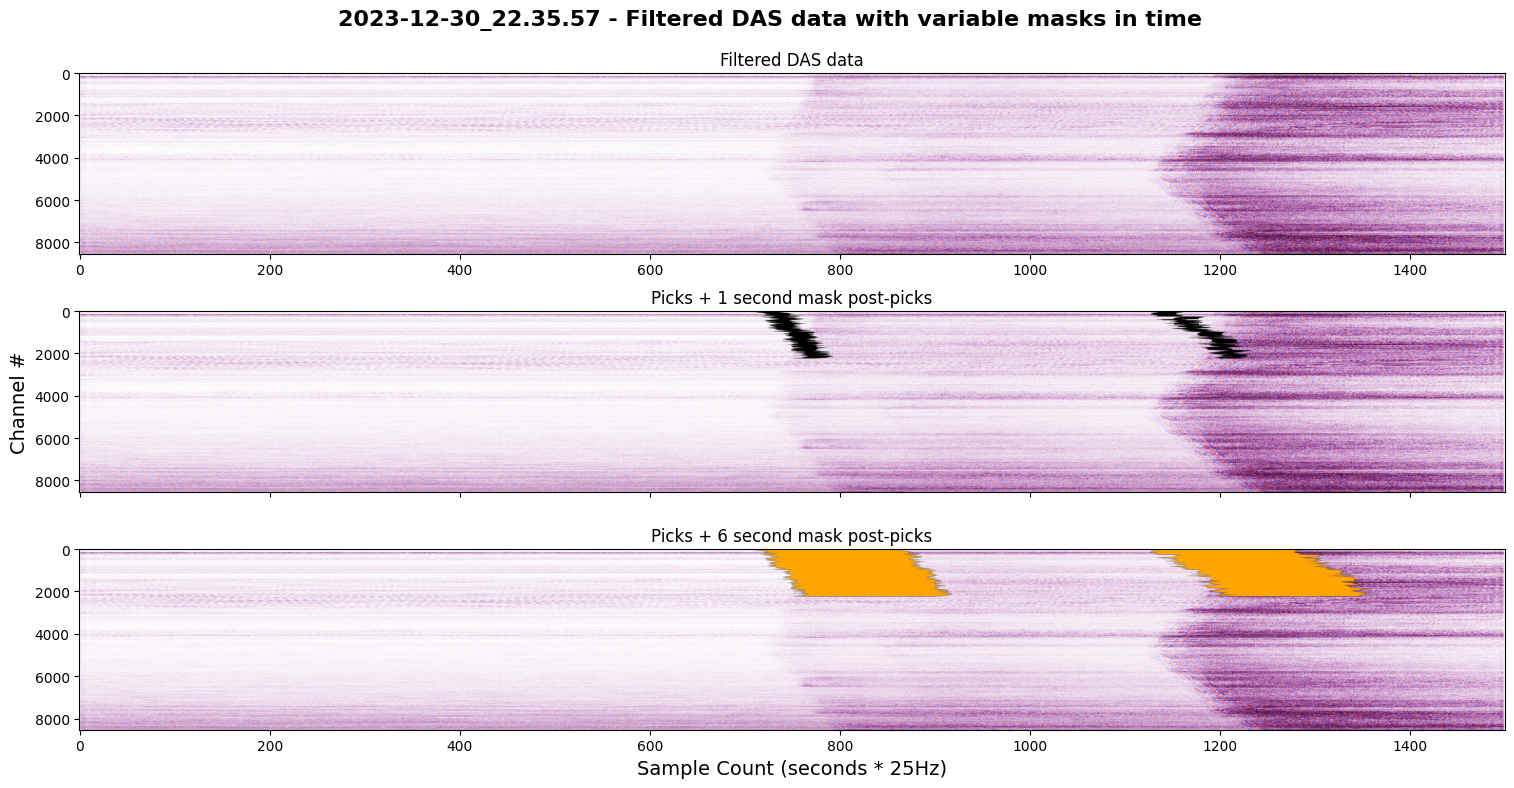